# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond Price Analysis & Prediction</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error

<a id="3"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Basic Exploration</p>


**Let's have a glimpse at the dataset.**

* **carat:** Weight(0.2 to 5.01) of the diamond
* **cut:** Quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* **color:** Diamond colour from J(worst) to D(best)
* **clarity:** Measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* **x:** Length(0 to 10.74) in mm 
* **y:** Width(0 to 58.9) in mm 
* **z:** Depth(0 to 31.8) in mm 
* **depth %:** The height of a diamond, measured from the culet to the table, divided by its average girdle diameter. Total depth percentage(43 to 79) = z/mean(x,y) = 2\*z/(x+y)
* **table:** Width(43 to 95) of the top of diamond relative to widest point 
* **price:** Price in US dollar

In [280]:
diamonds = pd.read_csv('diamonds.csv',index_col=False)
diamonds.head().style.set_properties(**{"background-color": "#FDD667","color":"black","border": "1.5px solid black"})

In [3]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48940 entries, 0 to 48939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    48940 non-null  float64
 1   cut      48940 non-null  object 
 2   color    48940 non-null  object 
 3   clarity  48940 non-null  object 
 4   depth    48940 non-null  float64
 5   table    48940 non-null  float64
 6   price    48940 non-null  int64  
 7   x        48940 non-null  float64
 8   y        48940 non-null  float64
 9   z        48940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.7+ MB


<a id="4"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Dataset Summary</p>

In [8]:
diamonds.describe().style.set_properties(**{"background-color": "#FDD667","color":"black","border": "1.5px solid black"})

In [284]:
diamonds.describe(include=object).T.style.set_properties(**{"background-color": "#FDD667","color":"black","border": "1.5px solid black"})

In [278]:
diamonds['color'].value_counts()

3    10280
1     8869
2     8650
4     7536
0     6159
5     4888
6     2540
Name: color, dtype: int64

In [12]:
# Any nulls?
diamonds.isna().sum().to_frame().T.style.set_properties(**{"background-color": "#FDD667","color":"black","border": "1.5px solid black"})

In [282]:
# The describe table finds values = 0 in x, y and z. How many?
len(diamonds.loc[(diamonds["x"] == 0) | (diamonds["y"] == 0) | (diamonds["z"] == 0)])

18

In [262]:
diamonds.shape

(48940, 10)

In [283]:
#dropping zeroes
diamonds = diamonds[(diamonds[["x", "y", "z"]] != 0).all(axis=1)].reset_index()
diamonds = diamonds.drop("index", axis=1)

In [264]:
diamonds.shape # check that all 0's have been dropped


(48922, 10)

In [300]:
diamonds.describe().style.set_properties(**{"background-color": "#FDD667","color":"black","border": "1.5px solid black"}) # this makes more sense now

**Insights:**

* Fixed the wrong values
* We will encode the categorical features into numerical ones later.

<a id="5"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Custom Palette For Visualization</p>

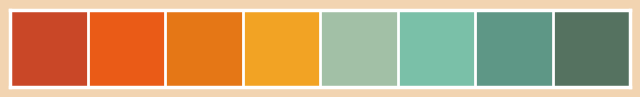

In [196]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#f2d4b1","figure.facecolor":"#f2d4b1","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

palette = ["#c94727","#ea5b17","#e57716","#f2a324","#a2c0a6","#7ac0a8","#5e9786","#557260"]

sns.palplot(sns.color_palette(palette))
plt.show()

<a id="6"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond Prices</p>

Let's have a look at the distribution of prices :


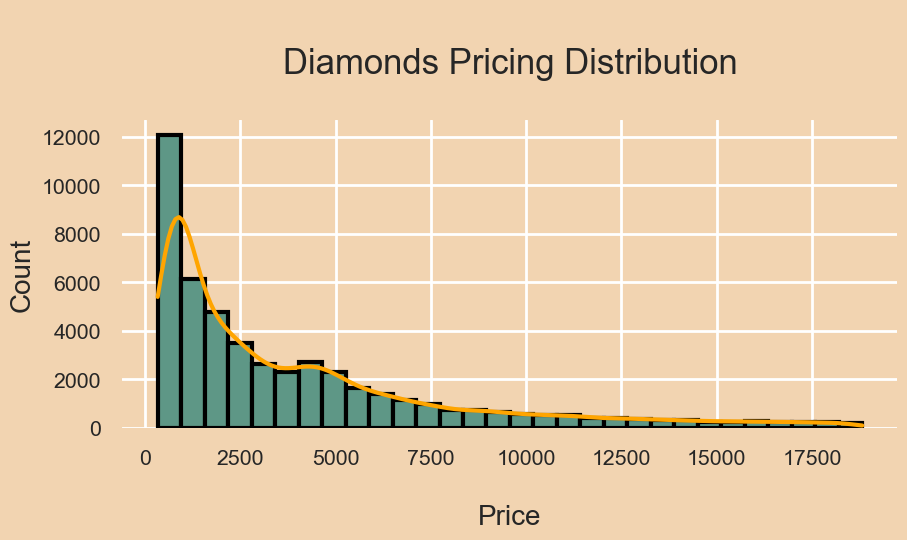

In [112]:
print("Let's have a look at the distribution of prices :")
plt.subplots(figsize=(10, 4))
p = sns.histplot(diamonds["price"],color=palette[6],kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamonds Pricing Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nPrice",fontsize=20)
plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

- "Price", as expected, is skewed. There are few diamonds which are worth too much and a lot of diamonds with reasonably small prices.

<a id="7"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond Cuts</p>

Let's have a look on the ratio of diamond's cut :


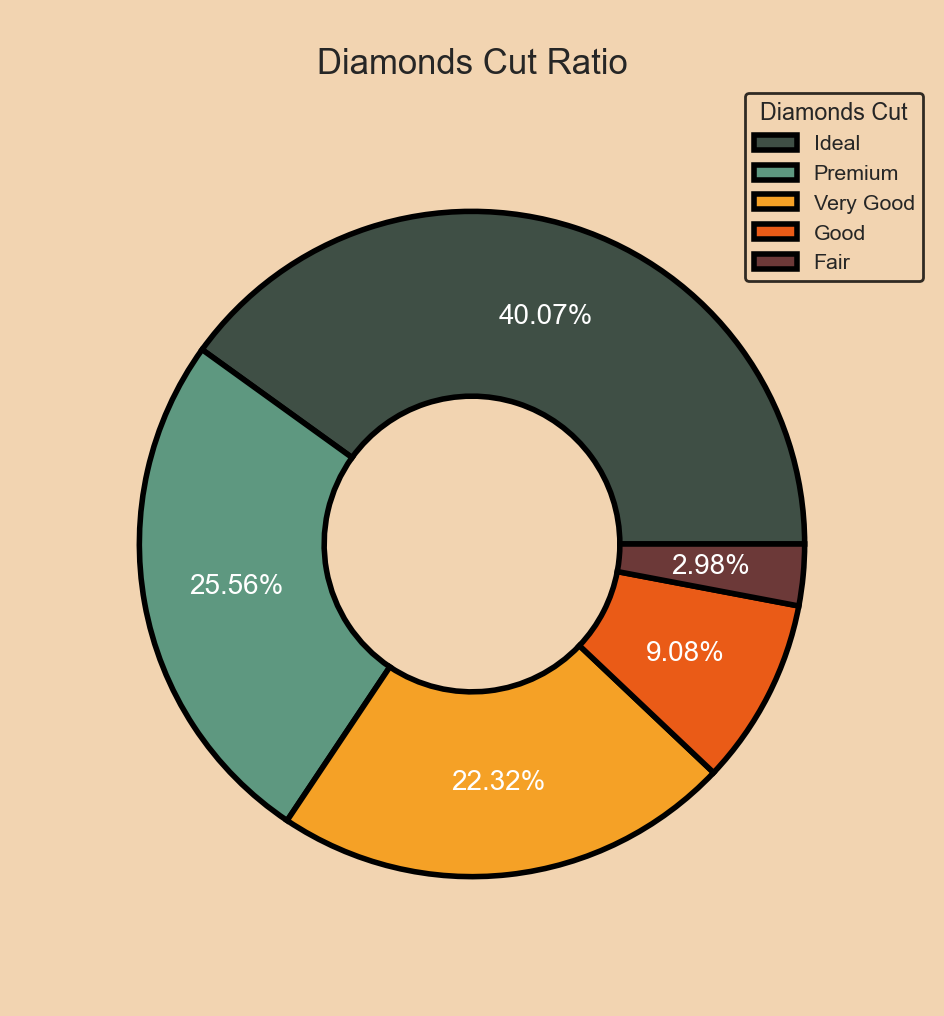

In [56]:
print(f"Let's have a look at the ratio of diamond cuts:")
plt.subplots(figsize=(12, 12))

labels = "Ideal","Premium","Very Good","Good","Fair"
size = 0.5

wedges, texts, autotexts = plt.pie([diamonds["cut"].value_counts().values[0],
                                    diamonds["cut"].value_counts().values[1],
                                    diamonds["cut"].value_counts().values[2],
                                    diamonds["cut"].value_counts().values[3],
                                    diamonds["cut"].value_counts().values[4]],
                                    explode = (0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.72,
                                    radius=.9, 
                                    colors = ["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"], 
                                    shadow = False,
                                    wedgeprops=dict(width = size, edgecolor = "black", 
                                    linewidth = 4),
                                    startangle = 0)

plt.legend(wedges, labels, title="Diamonds Cut",loc="upper right", edgecolor = "black") #,bbox_to_anchor=(1, 0, 0.5, 1)
plt.title("\nDiamonds Cut Ratio",fontsize=25)
plt.show()

On absolute values:


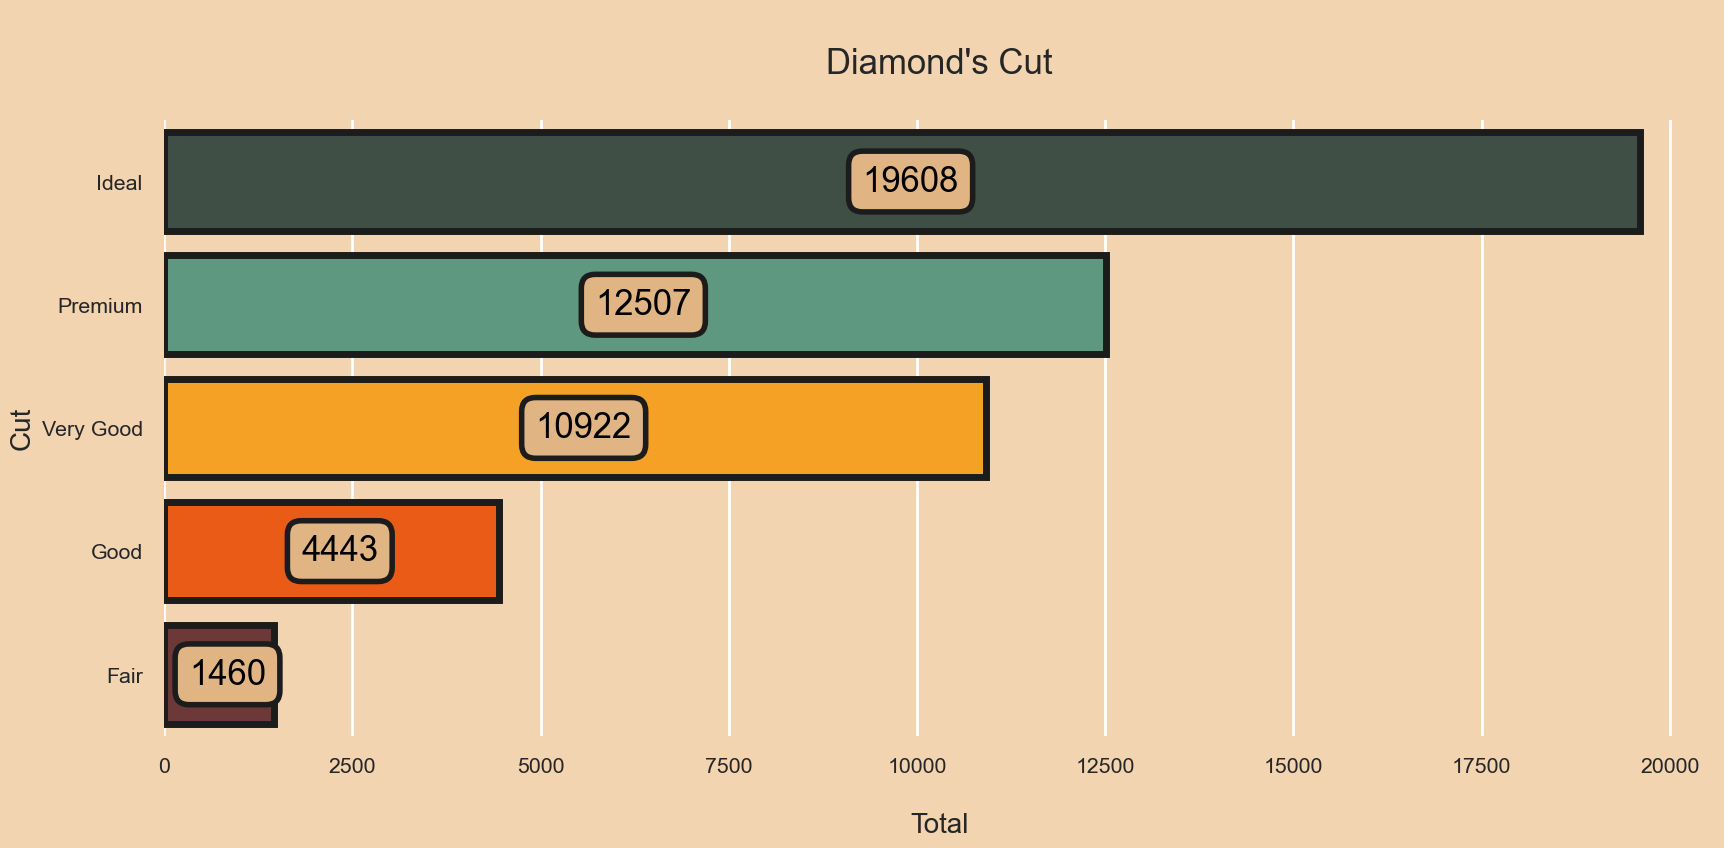

In [58]:
print("On absolute values:")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=diamonds["cut"],order=diamonds["cut"].value_counts().index,palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond's Cut\n",fontsize=25)
p.axes.set_ylabel("Cut",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=25,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

**Insights:**

* Most of the diamonds have **Ideal Cut** with a ratio of **39.95%** followed by **Premium Cut** and **Very Good Cut**
* Only few have **Fair Cut** with a ratio of **2.98%**.

Let's have a look at the price distribution of diamond cuts:


C:\Users\hbati\AppData\Local\Temp\ipykernel_23784\2994206778.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), size = 20)


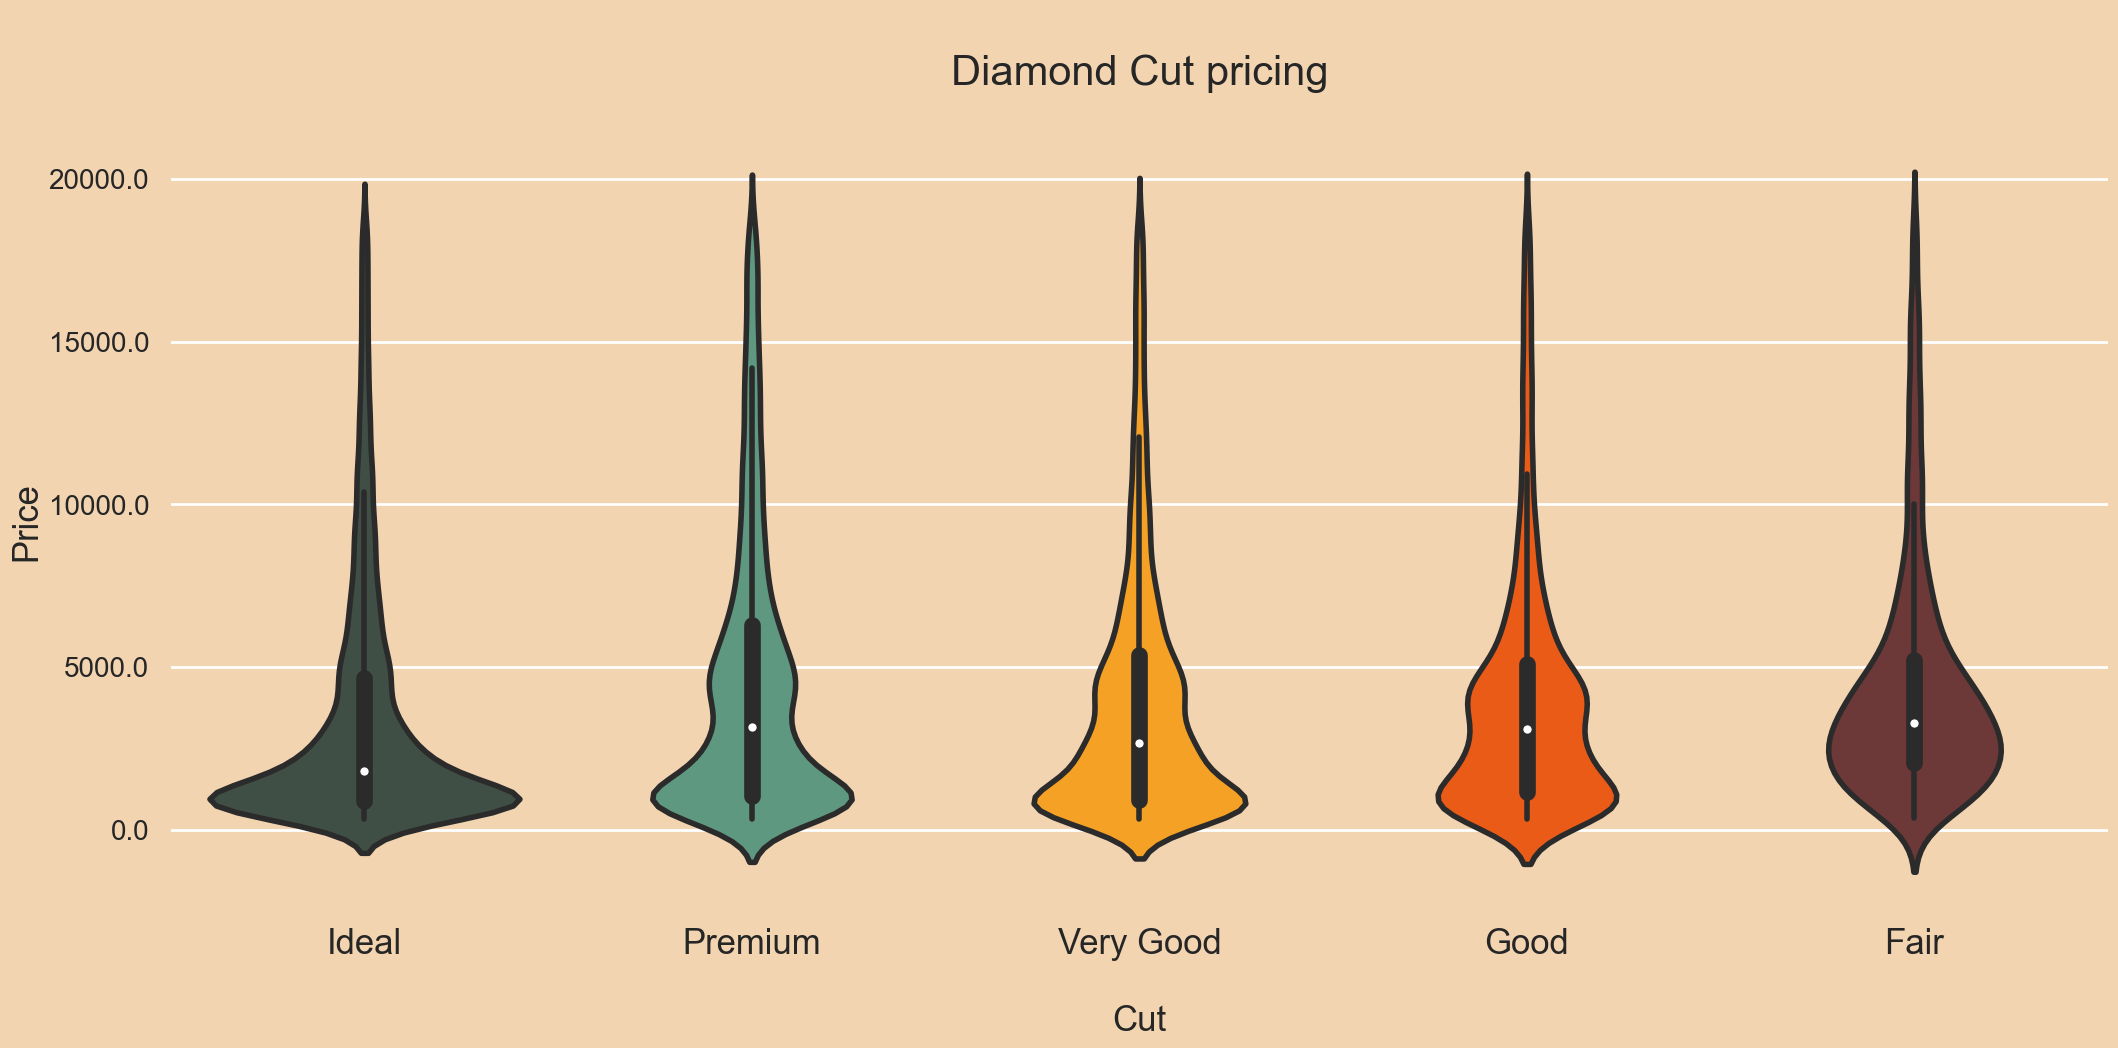

In [132]:
print("Let's have a look at the price distribution of diamond cuts:")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=diamonds["cut"],y=diamonds["price"],order=diamonds["cut"].value_counts().index,palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamond Cut pricing\n",fontsize=30)
p.axes.set_xlabel("\nCut",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)
p.set_yticklabels(p.get_yticks(), size = 20)
p.set_xticklabels(diamonds["cut"].value_counts().index, size = 25)

sns.despine(left=True, bottom=True)
plt.show()

**Insights:**

* Most of the diamonds with **Ideal Cut** costs in between **326** to **2500**
* Most of the diamonds with **Premium Cut** costs in between **326** to **5000**
* Most of the diamonds with **Very Good Cut** costs in between **336** to **4800**
* Most of the diamonds with **Good Cut** costs in between **327** to **4700**
* Most of the diamonds with **Fair Cut** costs in between **337** to **5000**

<a id="8"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond Colors</p>

In [75]:
diamonds["color"].value_counts().sort_index(ascending=True)

D     6160
E     8869
F     8653
G    10287
H     7542
I     4889
J     2540
Name: color, dtype: int64

Let's have a look at the ratio of diamond colors, which range from J (worst) to D (best):


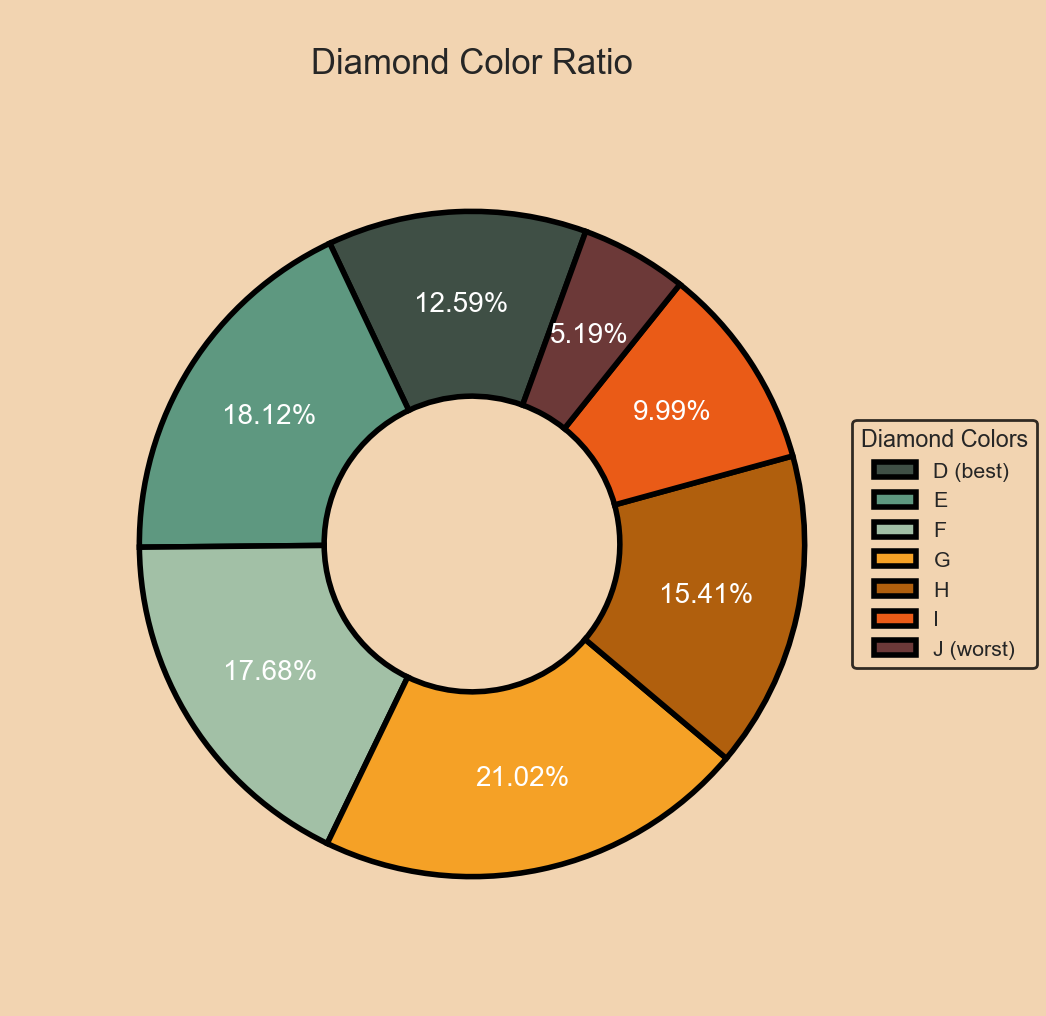

In [93]:
print(f"Let's have a look at the ratio of diamond colors, which range from J (worst) to D (best):")
plt.subplots(figsize=(12, 12))

labels = "D (best)","E","F","G","H","I","J (worst)"
size = 0.5

wedges, texts, autotexts = plt.pie([diamonds["color"].value_counts().sort_index(ascending=True).values[0],
                                    diamonds["color"].value_counts().sort_index(ascending=True).values[1],
                                    diamonds["color"].value_counts().sort_index(ascending=True).values[2],
                                    diamonds["color"].value_counts().sort_index(ascending=True).values[3],
                                    diamonds["color"].value_counts().sort_index(ascending=True).values[4],
                                    diamonds["color"].value_counts().sort_index(ascending=True).values[5],
                                    diamonds["color"].value_counts().sort_index(ascending=True).values[6]],
                                    explode = (0,0,0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.72,
                                    radius=.9, 
                                    colors = ["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"], 
                                    shadow = False,
                                    wedgeprops=dict(width = size, edgecolor = "black", 
                                    linewidth = 4),
                                    startangle = 70)

plt.legend(wedges, labels, title="Diamond Colors",loc="center left",bbox_to_anchor=(0.9, 0, 0.5, 1), edgecolor = "black")
plt.title("\nDiamond Color Ratio",fontsize=25)
plt.show()

Let's have a look at the absolute values now:


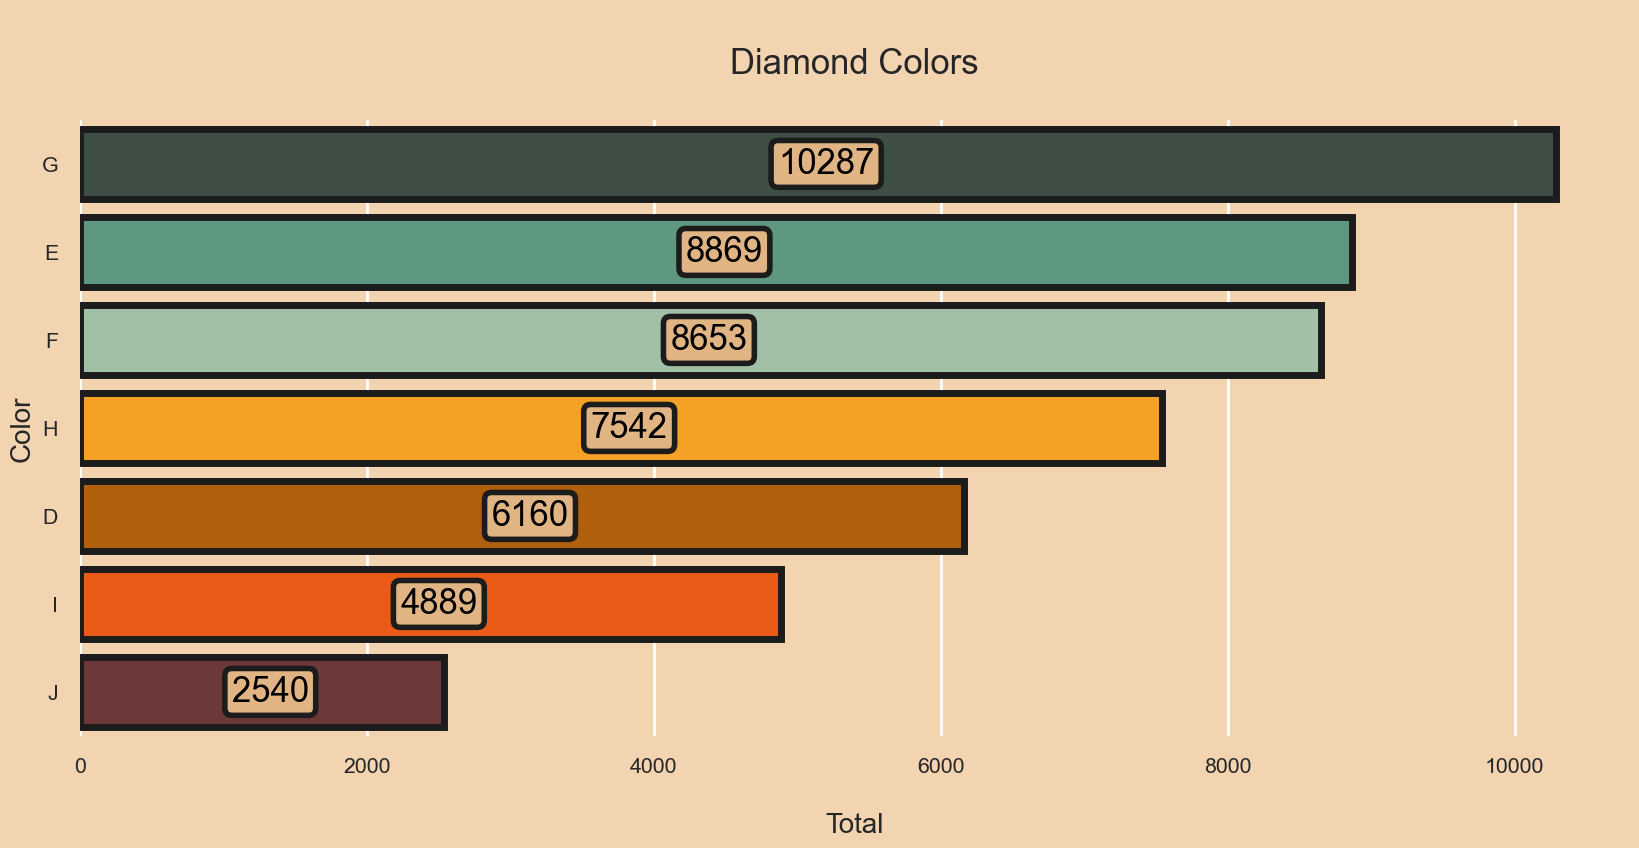

In [113]:
print("Let's have a look at the absolute values now:")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=diamonds["color"],order=diamonds["color"].value_counts().index,palette=["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond Colors\n",fontsize=25)
p.axes.set_ylabel("Color",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=25,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look at the price distribution of diamond colors:


C:\Users\hbati\AppData\Local\Temp\ipykernel_23784\1254886118.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), size = 20)


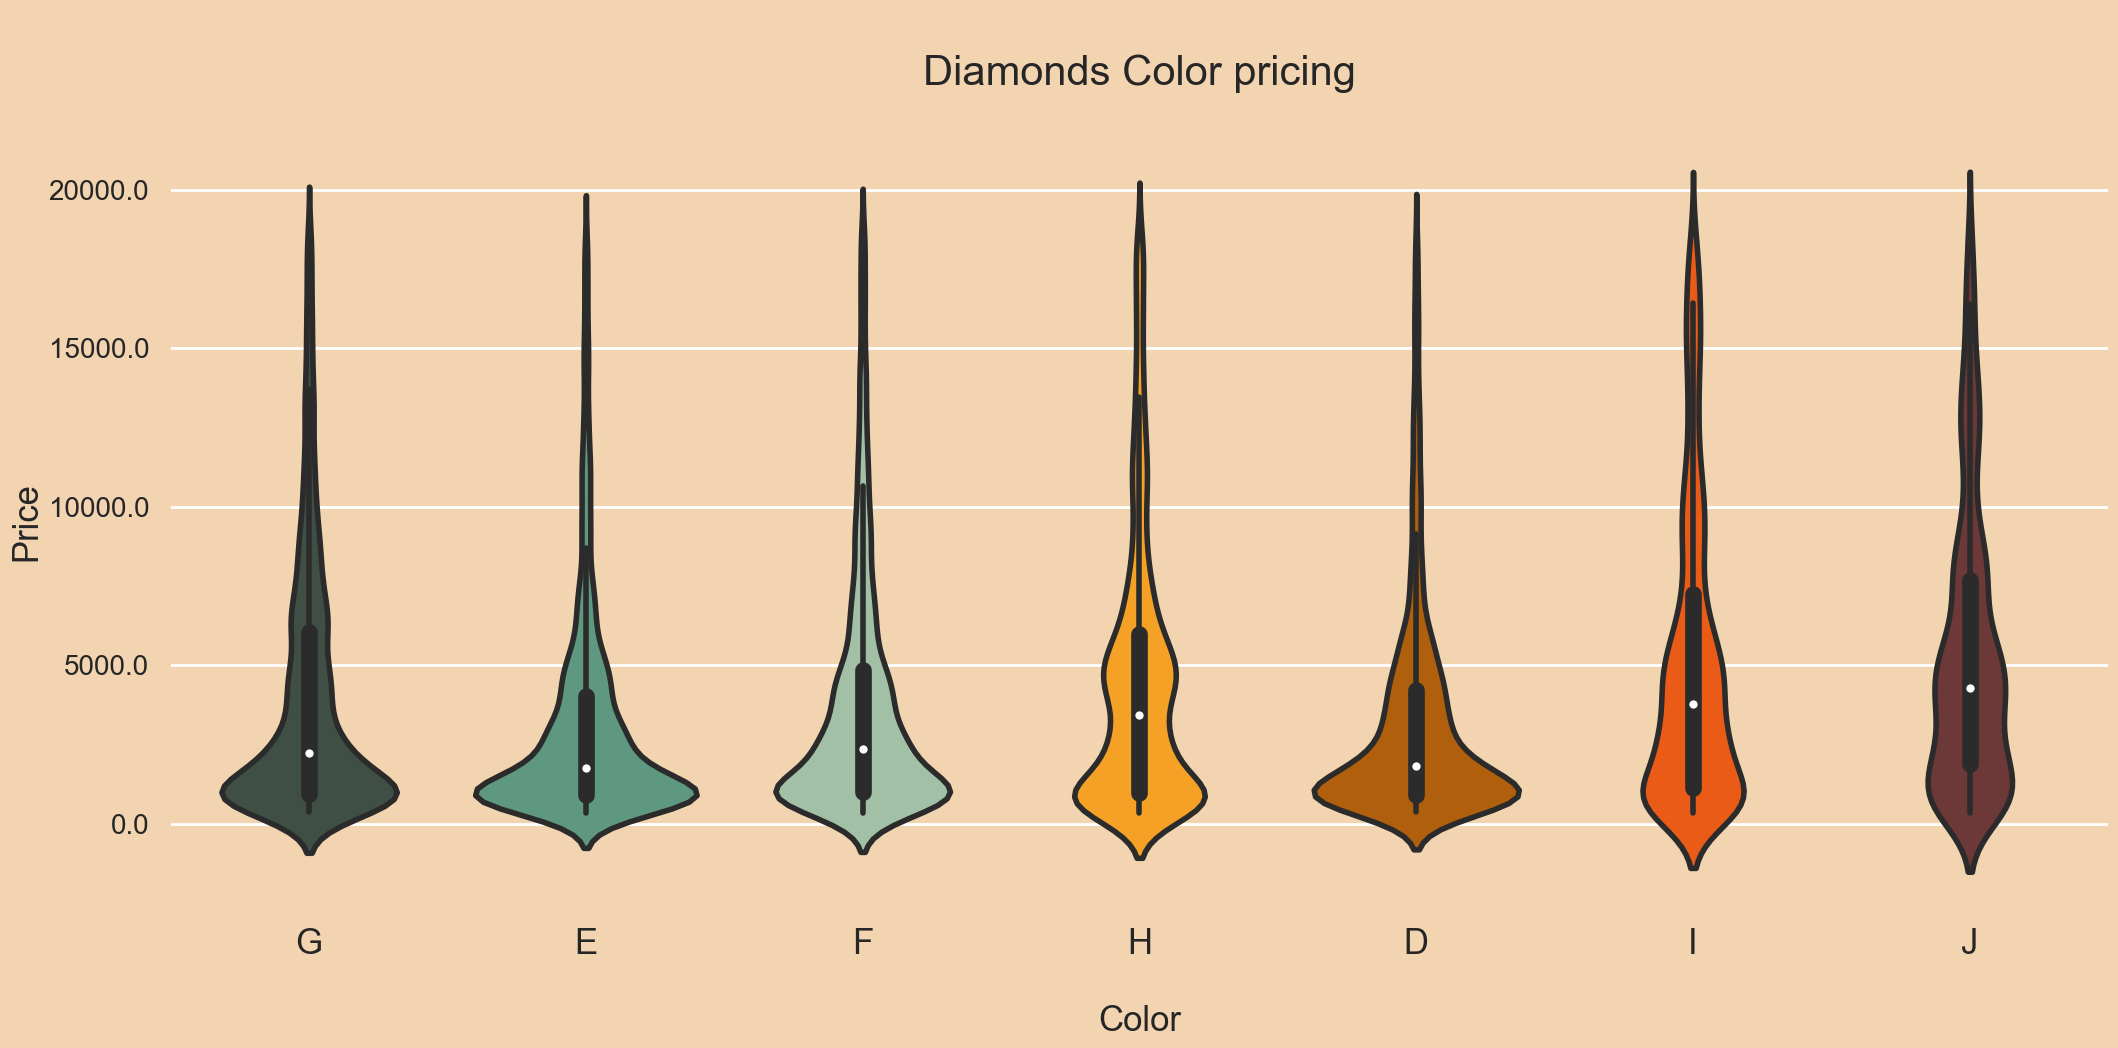

In [131]:
print("Let's have a look at the price distribution of diamond colors:")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=diamonds["color"],y=diamonds["price"],order=diamonds["color"].value_counts().index,palette=["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamonds Color pricing\n",fontsize=30)
p.axes.set_xlabel("\nColor",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)
p.set_yticklabels(p.get_yticks(), size = 20)
p.set_xticklabels(diamonds["color"].value_counts().index, size = 25)

sns.despine(left=True, bottom=True)
plt.show()

<a id="9"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond Clarities</p>

Let's have a look at the ratio of diamond clarities. The range is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)):


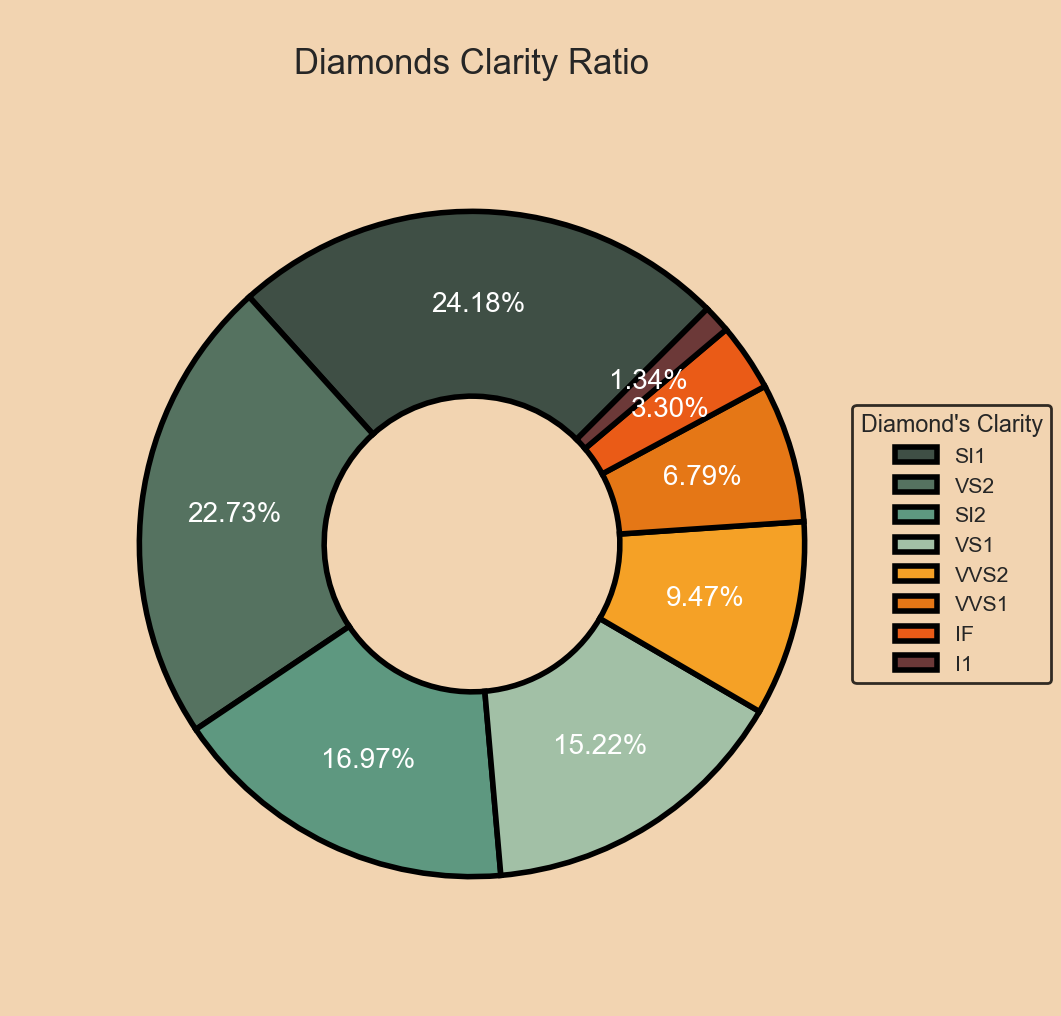

In [144]:
print(f"Let's have a look at the ratio of diamond clarities. The range is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)):")
plt.subplots(figsize=(12, 12))

labels = "SI1","VS2","SI2","VS1","VVS2","VVS1","IF","I1"
size = 0.5

wedges, texts, autotexts = plt.pie([diamonds["clarity"].value_counts().values[0],
                                    diamonds["clarity"].value_counts().values[1],
                                    diamonds["clarity"].value_counts().values[2],
                                    diamonds["clarity"].value_counts().values[3],
                                    diamonds["clarity"].value_counts().values[4],
                                    diamonds["clarity"].value_counts().values[5],
                                    diamonds["clarity"].value_counts().values[6],
                                    diamonds["clarity"].value_counts().values[7]],
                                    explode = (0,0,0,0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.72,
                                    radius=.9, 
                                    colors = ["#3f4f45","#557260","#5e9880","#a2c0a6","#f5a126","#e57716","#ea5b17","#6c3938"], 
                                    shadow = False,
                                    wedgeprops=dict(width = size, edgecolor = "black", 
                                    linewidth = 4),
                                    startangle = 45)

plt.legend(wedges, labels, title="Diamond's Clarity",loc="center left",bbox_to_anchor=(0.9, 0, 0.5, 1), edgecolor = "black")
plt.title("\nDiamonds Clarity Ratio",fontsize=25)
plt.show()

In absolute values, we get


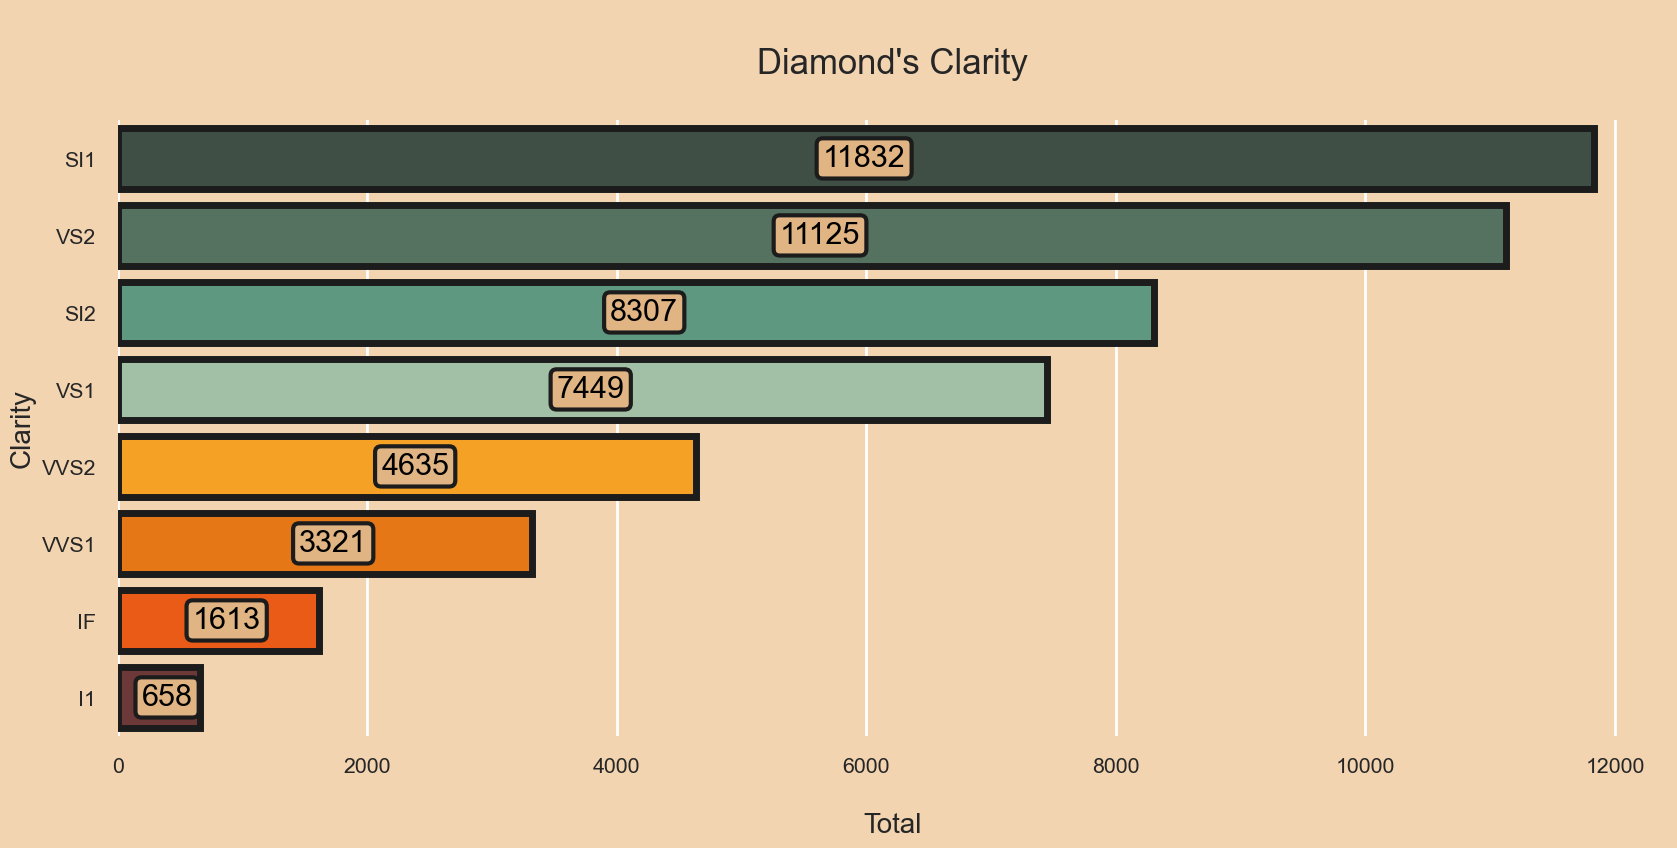

In [145]:
print("In absolute values, we get")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=diamonds["clarity"],order=diamonds["clarity"].value_counts().index,palette=["#3f4f45","#557260","#5e9880","#a2c0a6","#f5a126","#e57716","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond's Clarity\n",fontsize=25)
p.axes.set_ylabel("Clarity",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=22,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 3, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

**Insights:**

* Most of the diamonds have **SI1** clarity with a ratio of **24.22%** followed by **VS2** and **SI2**
* Only few have **I1** clarity with a ratio of **1.37%**.

Let's have a look at the pricing distribution of diamond clarities:


C:\Users\hbati\AppData\Local\Temp\ipykernel_23784\3189696281.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), size = 20)


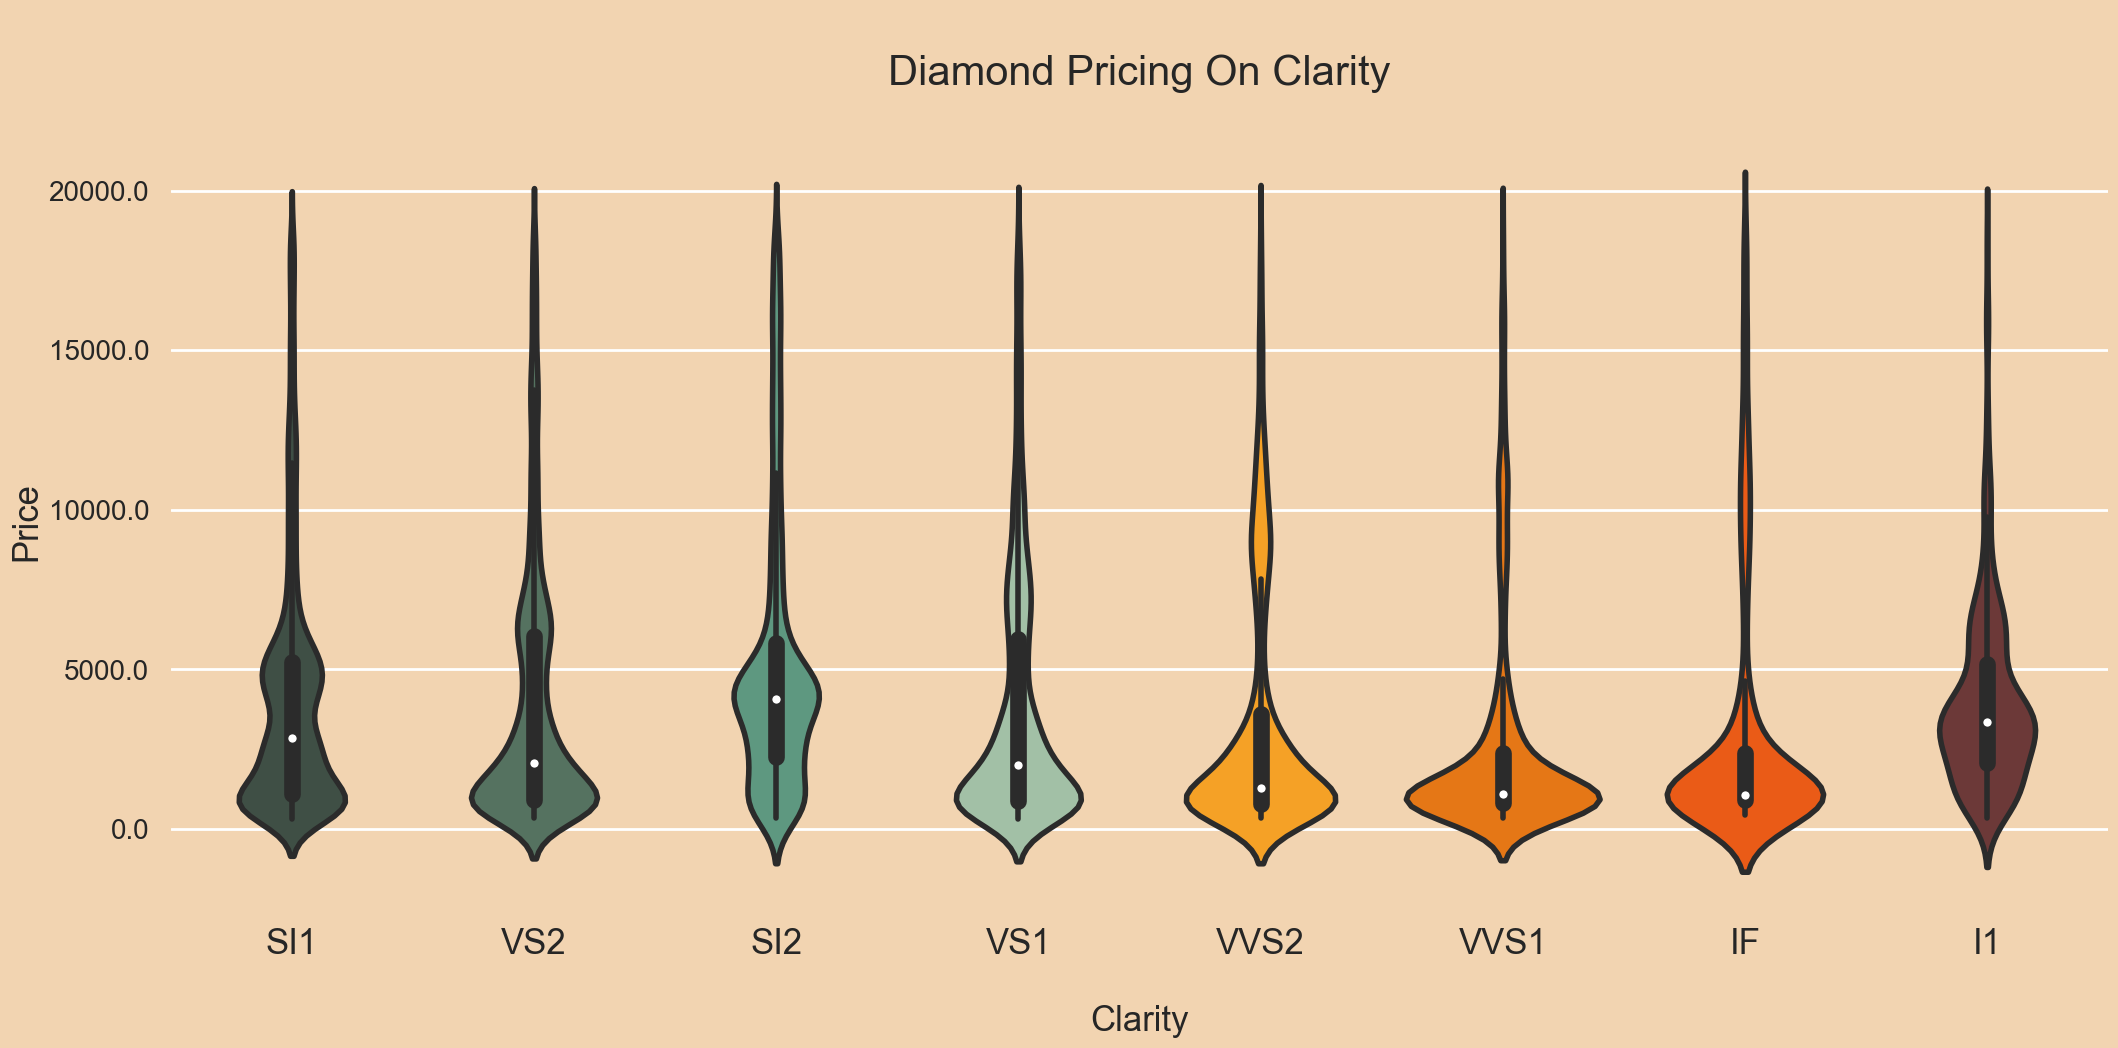

In [150]:
print("Let's have a look at the pricing distribution of diamond clarities:")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=diamonds["clarity"],y=diamonds["price"],order=diamonds["clarity"].value_counts().index,palette=["#3f4f45","#557260","#5e9880","#a2c0a6","#f5a126","#e57716","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamond Pricing On Clarity\n",fontsize=30)
p.axes.set_xlabel("\nClarity",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)
p.set_yticklabels(p.get_yticks(), size = 20)
p.set_xticklabels(diamonds["clarity"].value_counts().index, size = 25)

sns.despine(left=True, bottom=True)
plt.show()

<a id="10"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond Weights (in Carat)</p>

Let's have a look at the distribution of diamond weights:


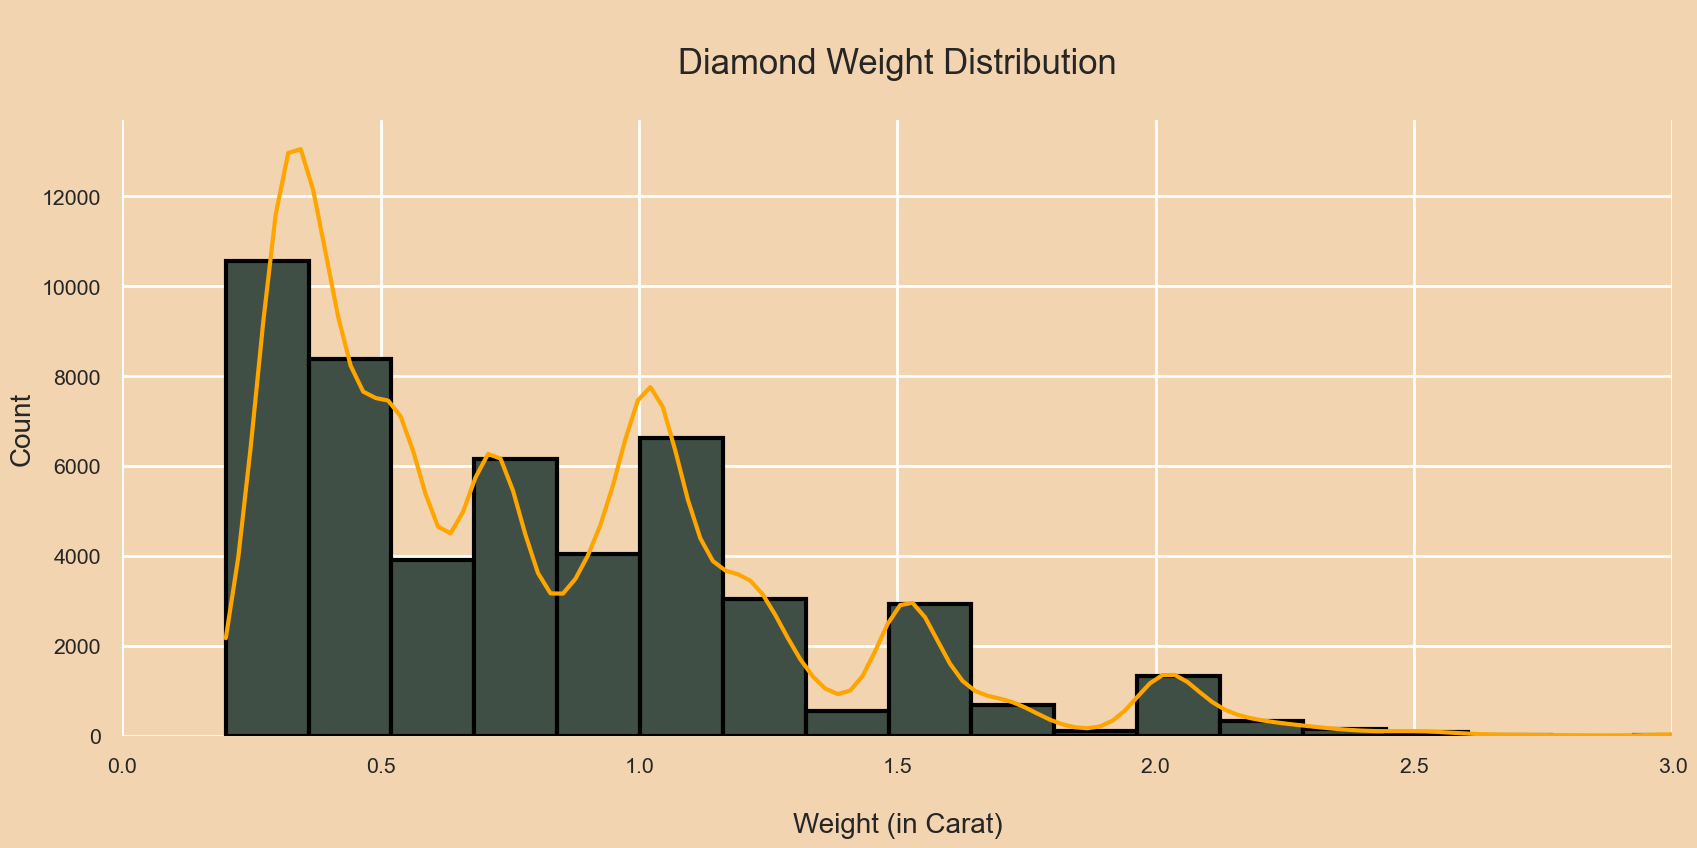

In [156]:
print(f"Let's have a look at the distribution of diamond weights:")
plt.subplots(figsize=(20, 8))
p = sns.histplot(diamonds["carat"],color="#3f4f45",kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond Weight Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nWeight (in Carat)",fontsize=20)
plt.xlim(0, 3)
# plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look at the price distribution of weights:


d:\Anaconda\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'kind', 'height'
  cset = contour_func(


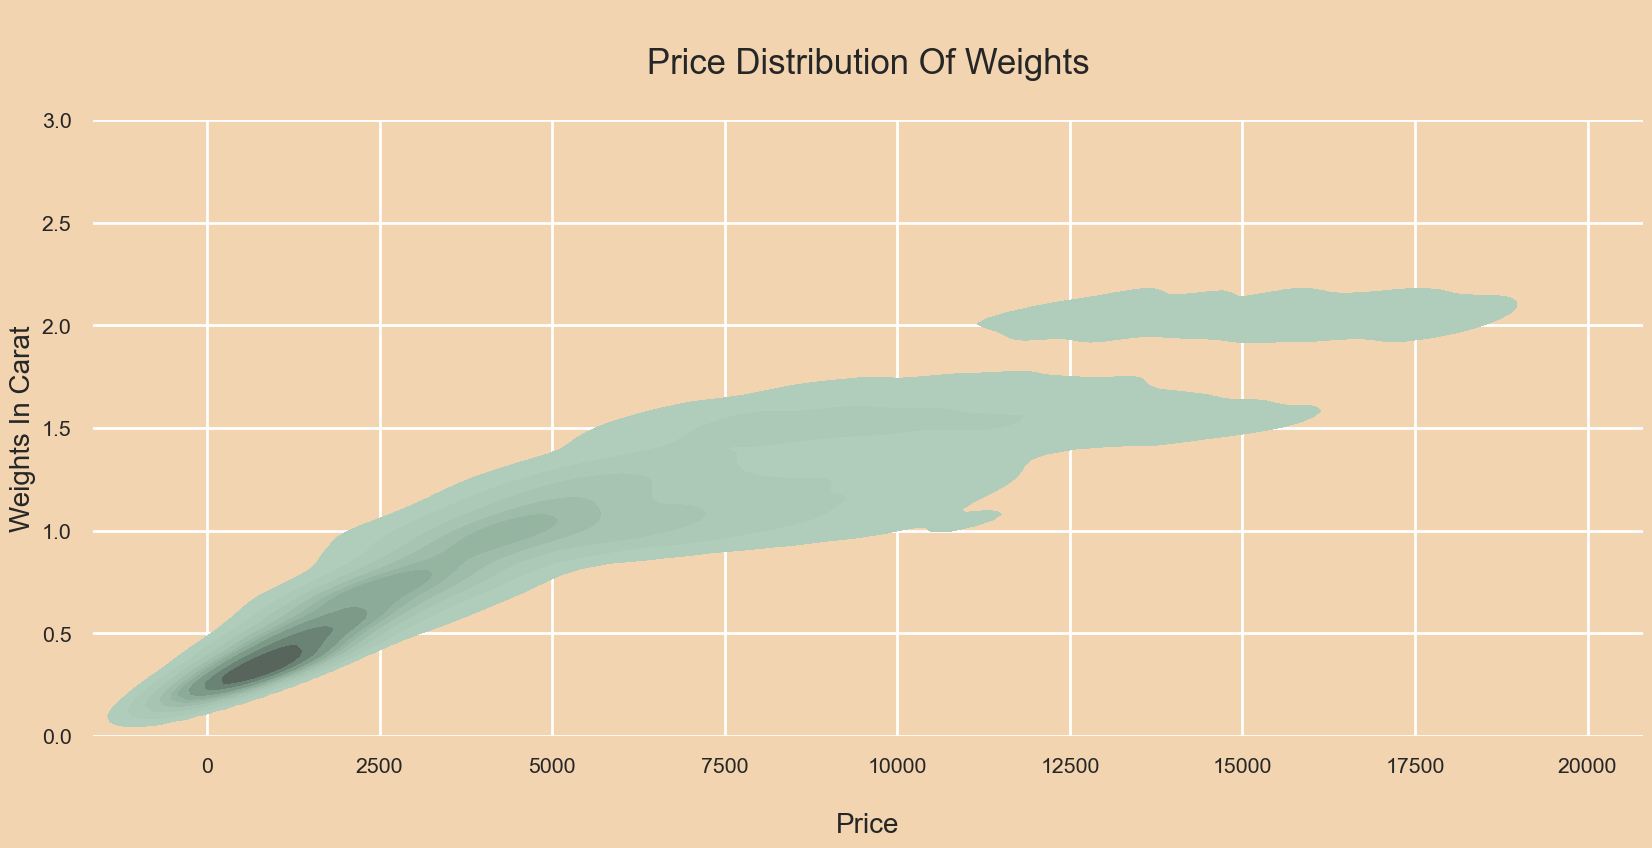

In [159]:
print("Let's have a look at the price distribution of weights:")

_, axes = plt.subplots(figsize=(20,8))
sns.kdeplot(y=diamonds["carat"], x=diamonds["price"],edgecolor="#1c1c1c",fill=True, kind="kde",shade=True,height=10,color="#3f4f45")
axes.set_title("\nPrice Distribution Of Weights\n",fontsize=25)
axes.set_xlabel("\nPrice",fontsize=20)
axes.set_ylabel("Weights In Carat",fontsize=20)
axes.set_ylim(0, 3)
    
sns.despine(left=True, bottom=True)
plt.show()

<a id="11"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond's Depth Percentage</p>

Let's have a look at the distribution of depth percentages:


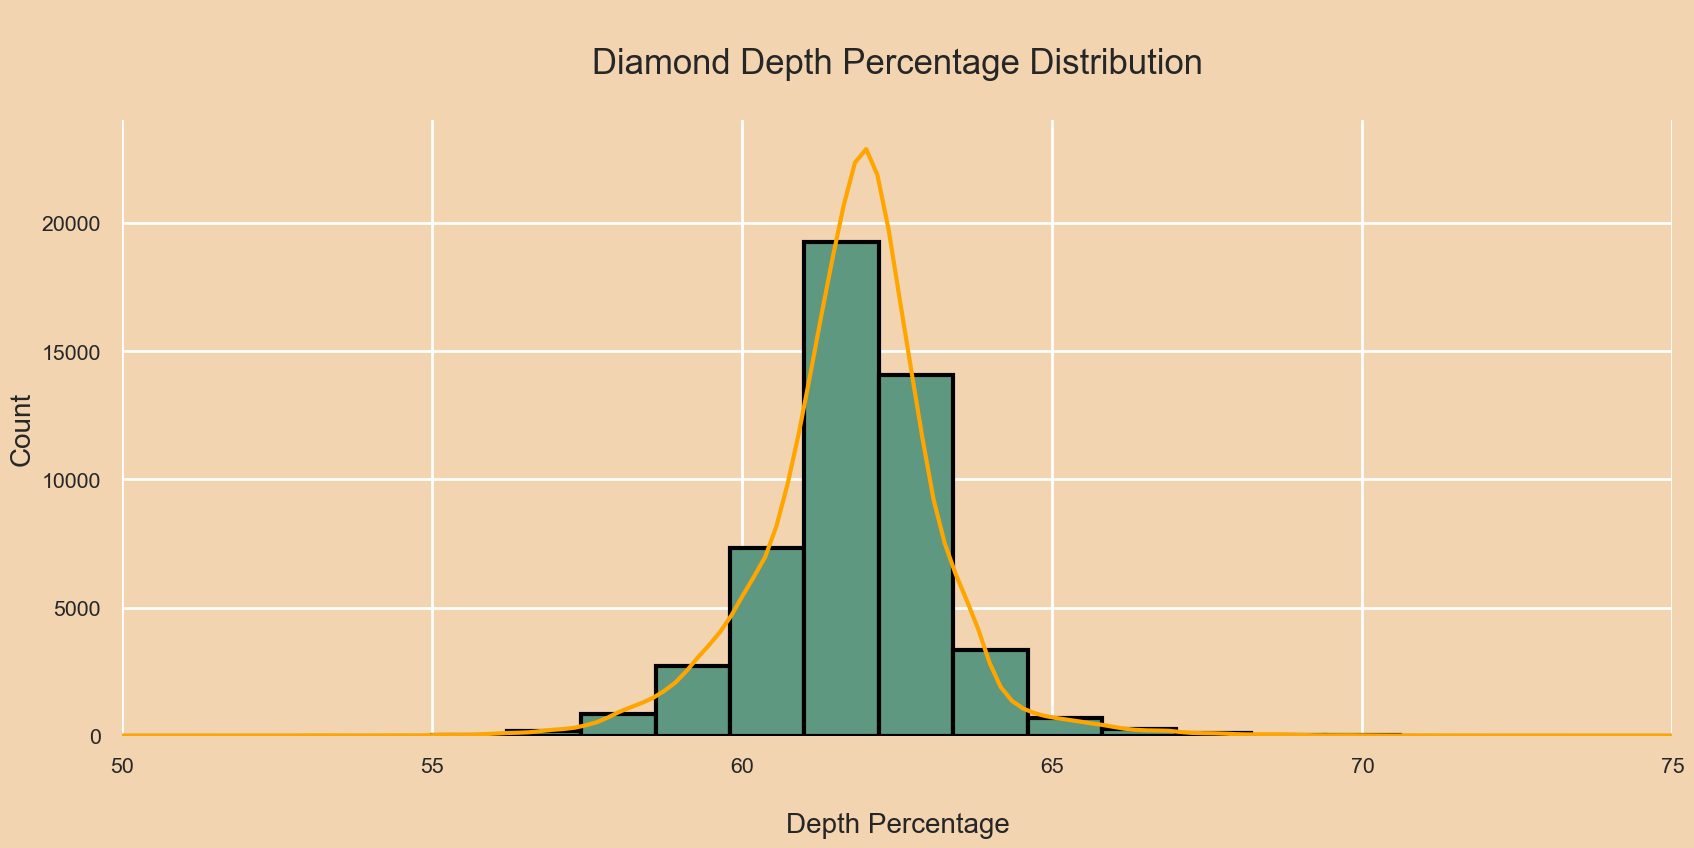

In [165]:
print(f"Let's have a look at the distribution of depth percentages:")
plt.subplots(figsize=(20, 8))
p = sns.histplot(diamonds["depth"],color="#5e9880",kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond Depth Percentage Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nDepth Percentage",fontsize=20)
plt.xlim(50, 75)
# plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look at the price distribution of depth percentage :


d:\Anaconda\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'kind', 'height'
  cset = contour_func(


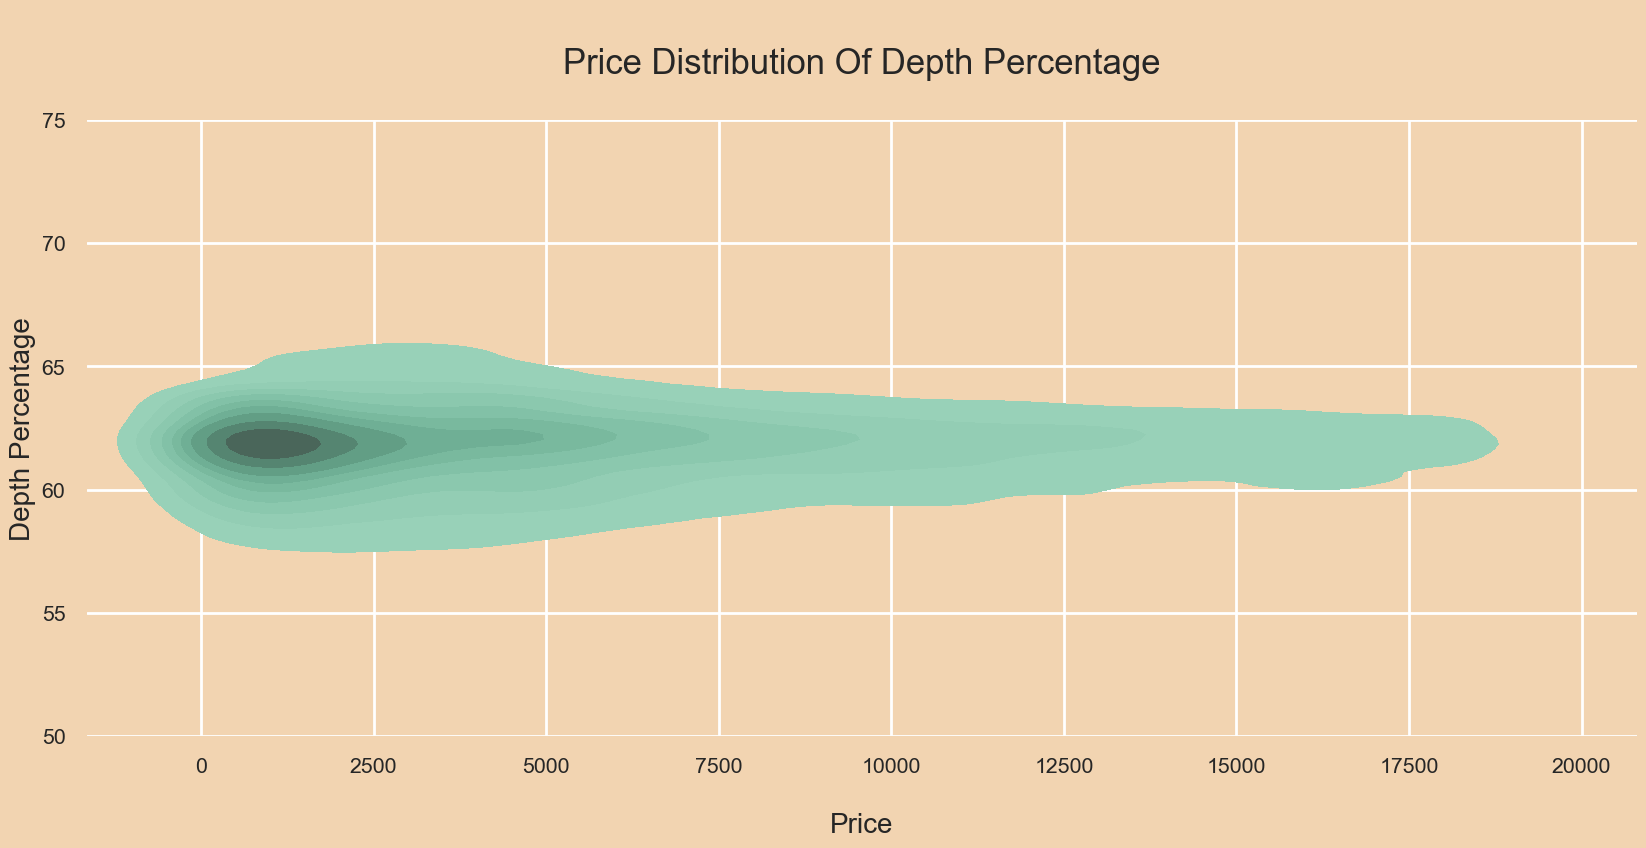

In [167]:
print("Let's have a look at the price distribution of depth percentage :")

_, axes = plt.subplots(figsize=(20,8))
sns.kdeplot(y=diamonds["depth"], x=diamonds["price"],edgecolor="#1c1c1c",fill=True, kind="kde",shade=True,height=10,color="#5e9880")
axes.set_title("\nPrice Distribution Of Depth Percentage\n",fontsize=25)
axes.set_xlabel("\nPrice",fontsize=20)
axes.set_ylabel("Depth Percentage",fontsize=20)
axes.set_ylim(50, 75)

sns.despine(left=True, bottom=True)
plt.show()

<a id="12"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Diamond's Table</p>

Let's have a look at the distribution of diamond tables:


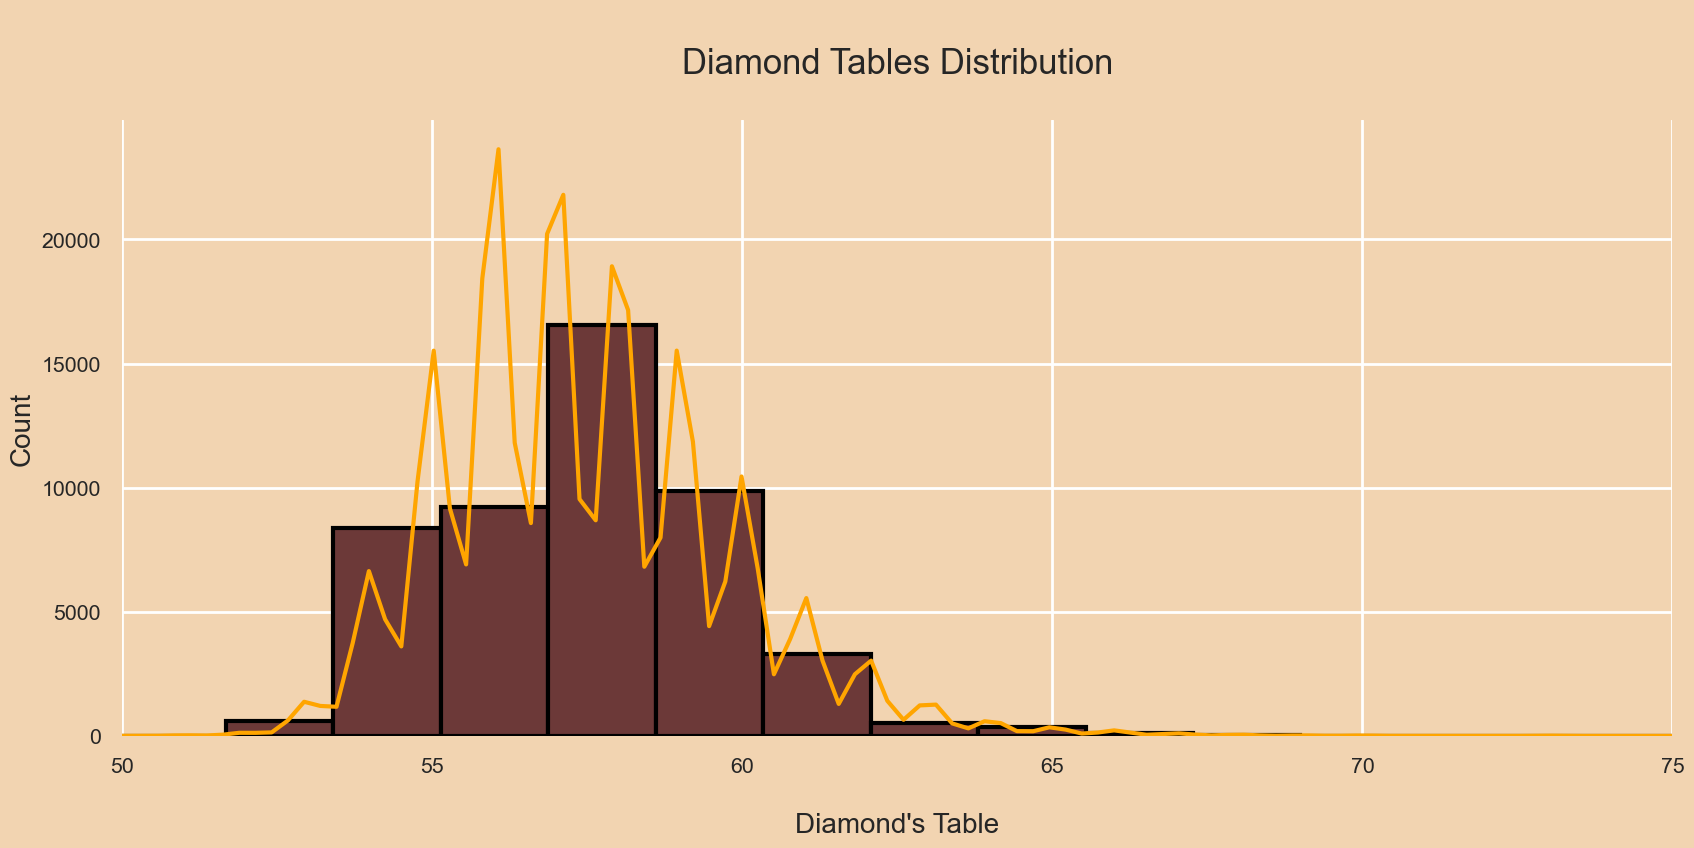

In [170]:
print(f"Let's have a look at the distribution of diamond tables:")
plt.subplots(figsize=(20, 8))
p = sns.histplot(diamonds["table"],color="#6c3938",kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond Tables Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nDiamond's Table",fontsize=20)
plt.xlim(50, 75)
# plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a lookat the price distribution of diamond tables:


d:\Anaconda\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'kind', 'height'
  cset = contour_func(


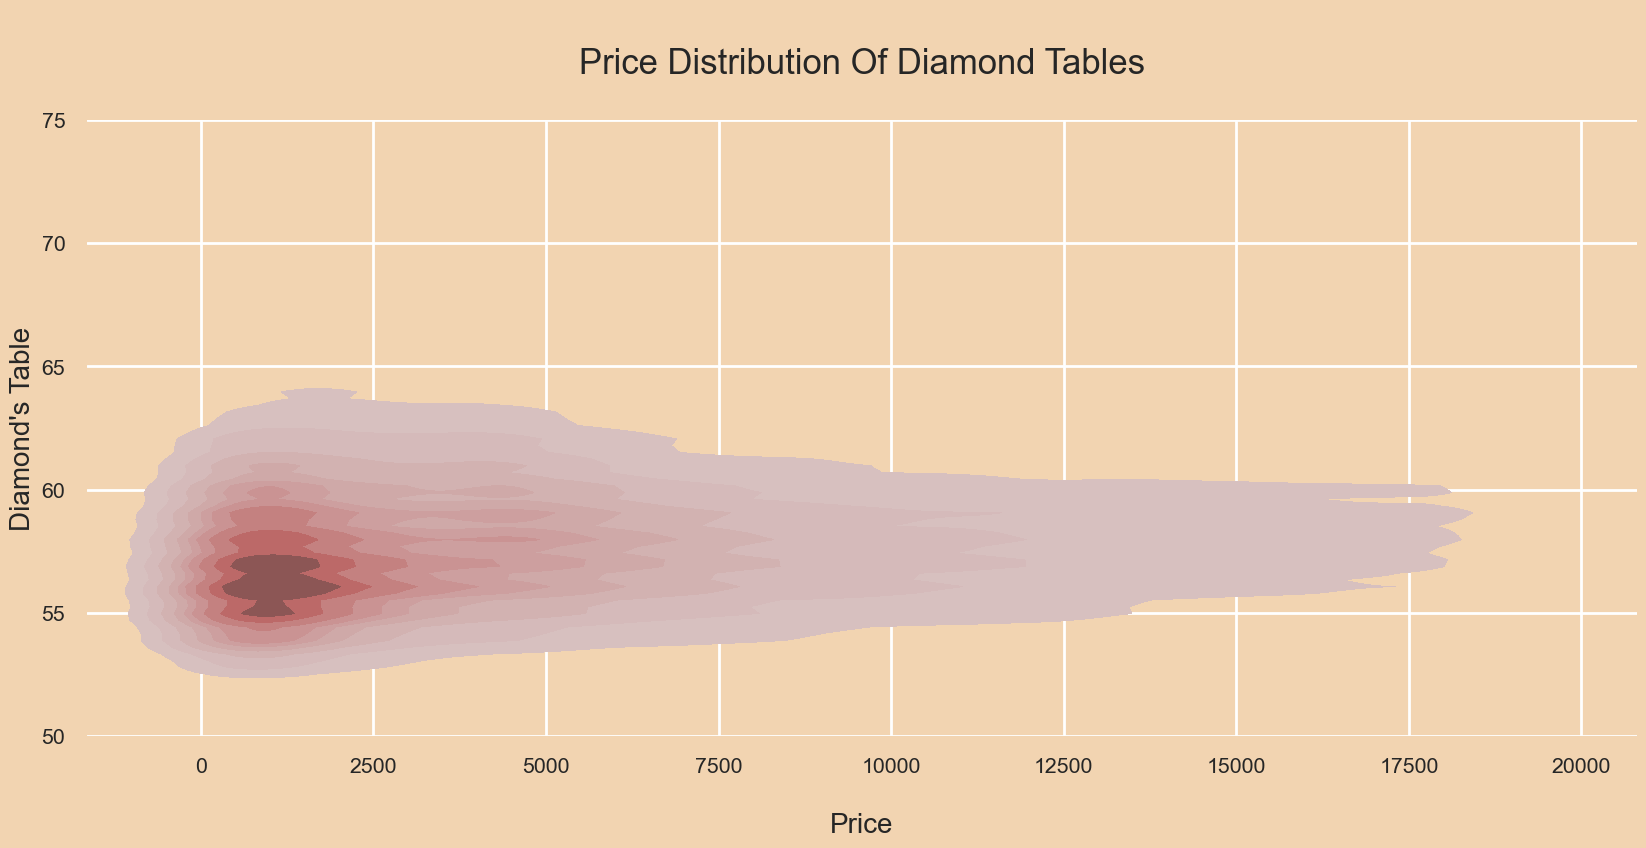

In [172]:
print("Let's have a lookat the price distribution of diamond tables:")

_, axes = plt.subplots(figsize=(20,8))
sns.kdeplot(y=diamonds["table"], x=diamonds["price"],edgecolor="#1c1c1c",fill=True, kind="kde",shade=True,height=10,color="#6c3938")
axes.set_title("\nPrice Distribution Of Diamond Tables\n",fontsize=25)
axes.set_xlabel("\nPrice",fontsize=20)
axes.set_ylabel("Diamond's Table",fontsize=20)
axes.set_ylim(50, 75)
    
sns.despine(left=True, bottom=True)
plt.show()

<a id="13"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Outlier Detection</p>

In [192]:
sns.pairplot(diamonds, diag_kind = 'kde')

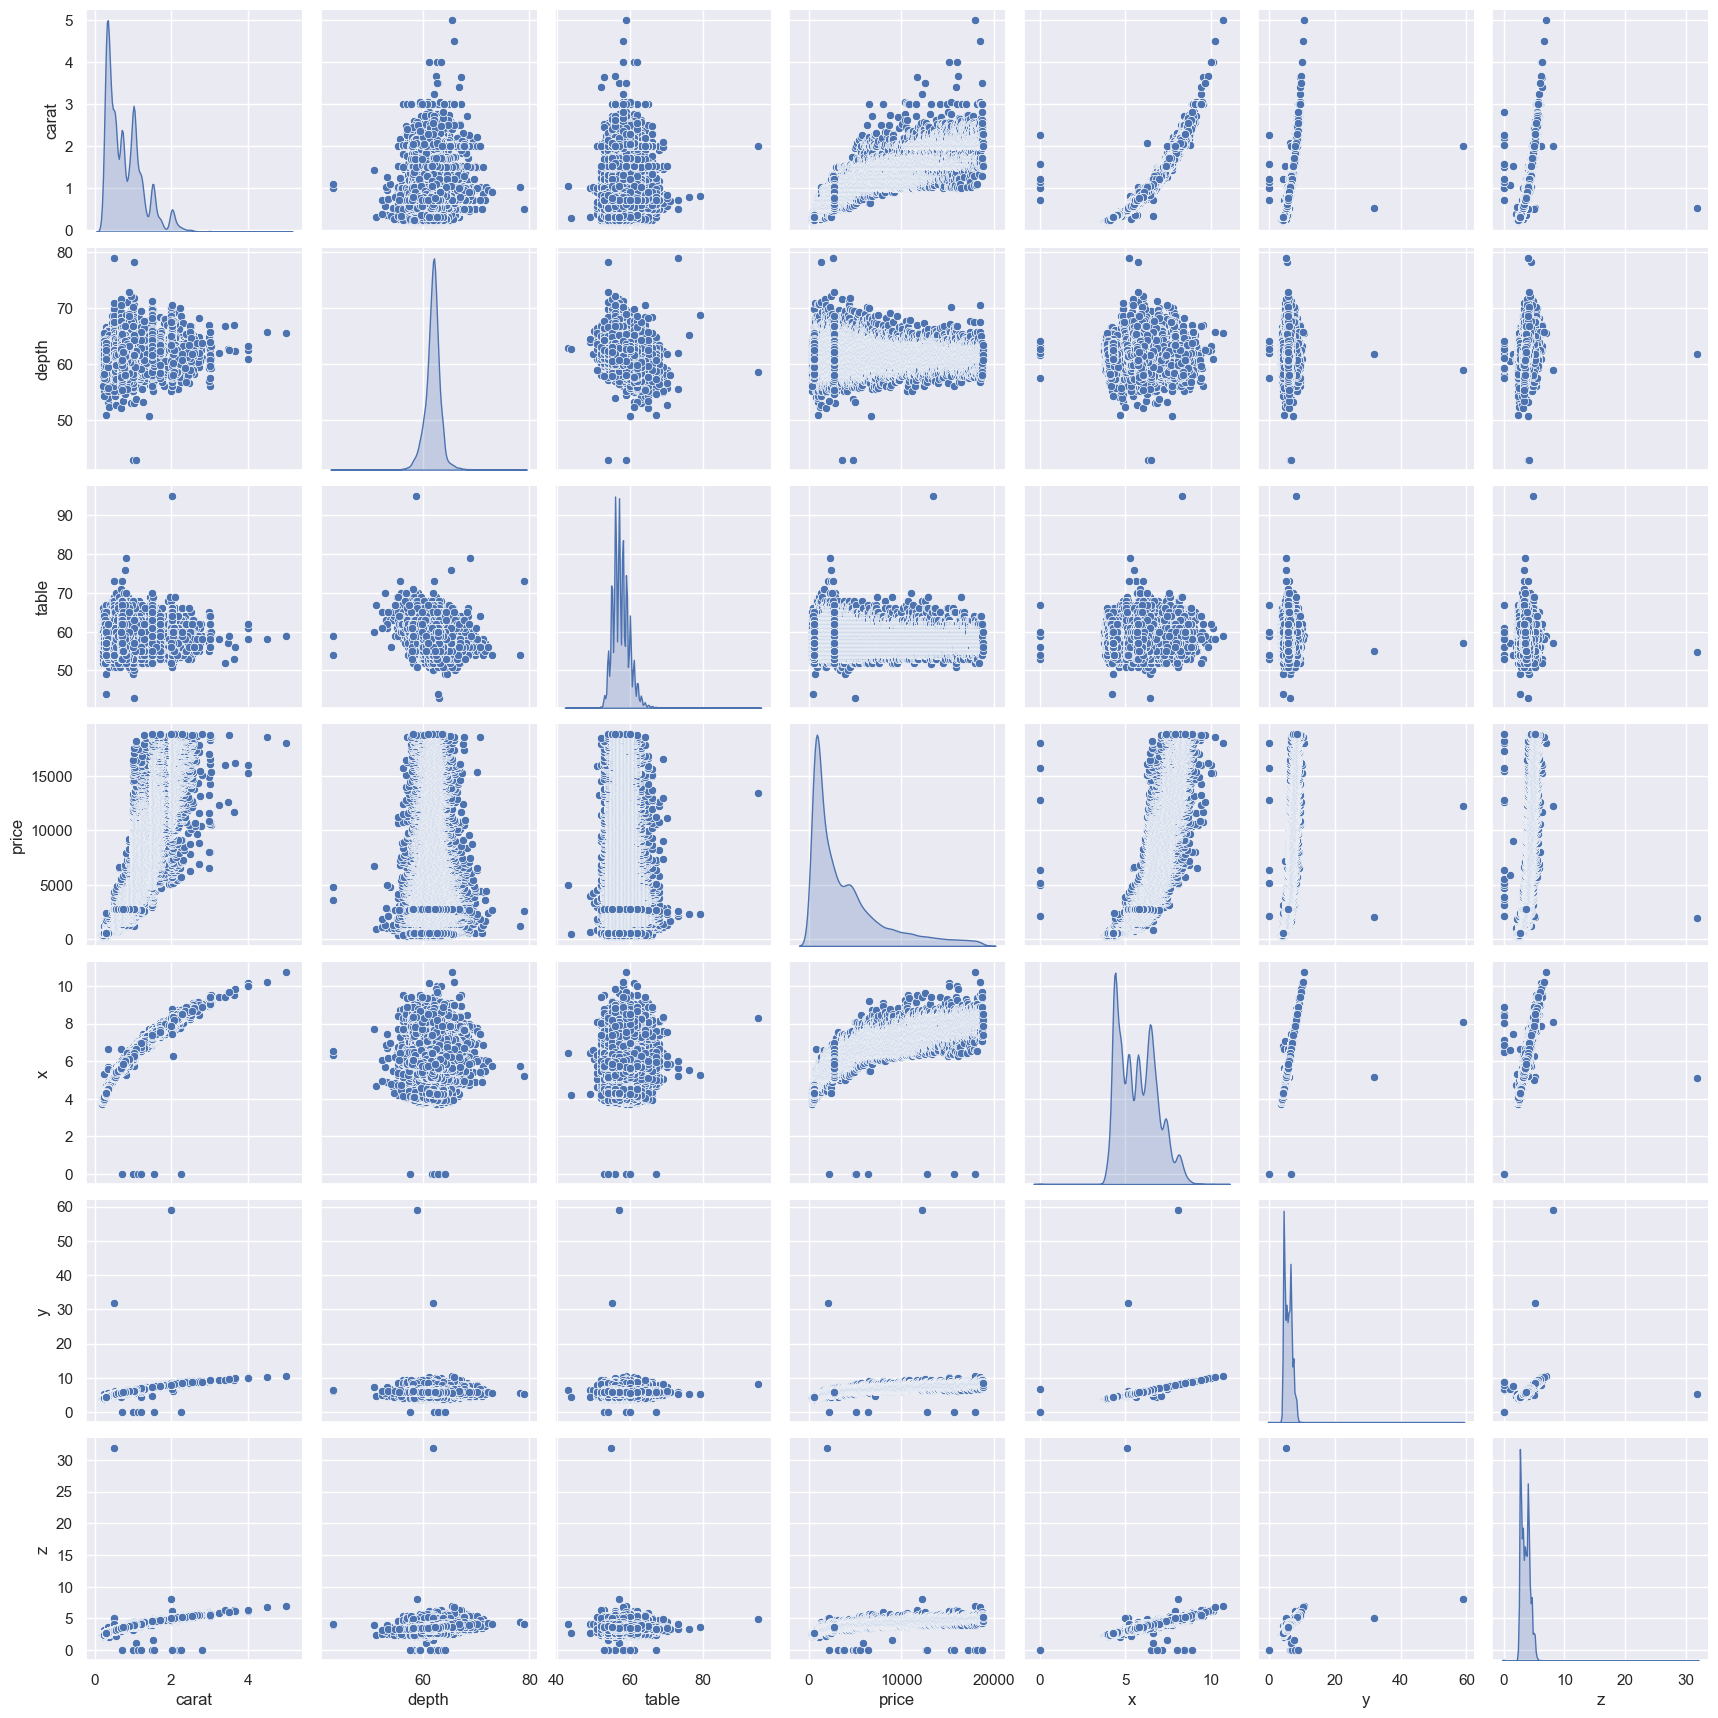

In [193]:
plt.show()

**Insights:**

- The pairplot immediately tells us that there are some features with diamondspoints that are far from the rest of its colleagues. This will affect the outcome of our regression model and hence they will be removed.
* Let's examine the regression line in these distributions as well.

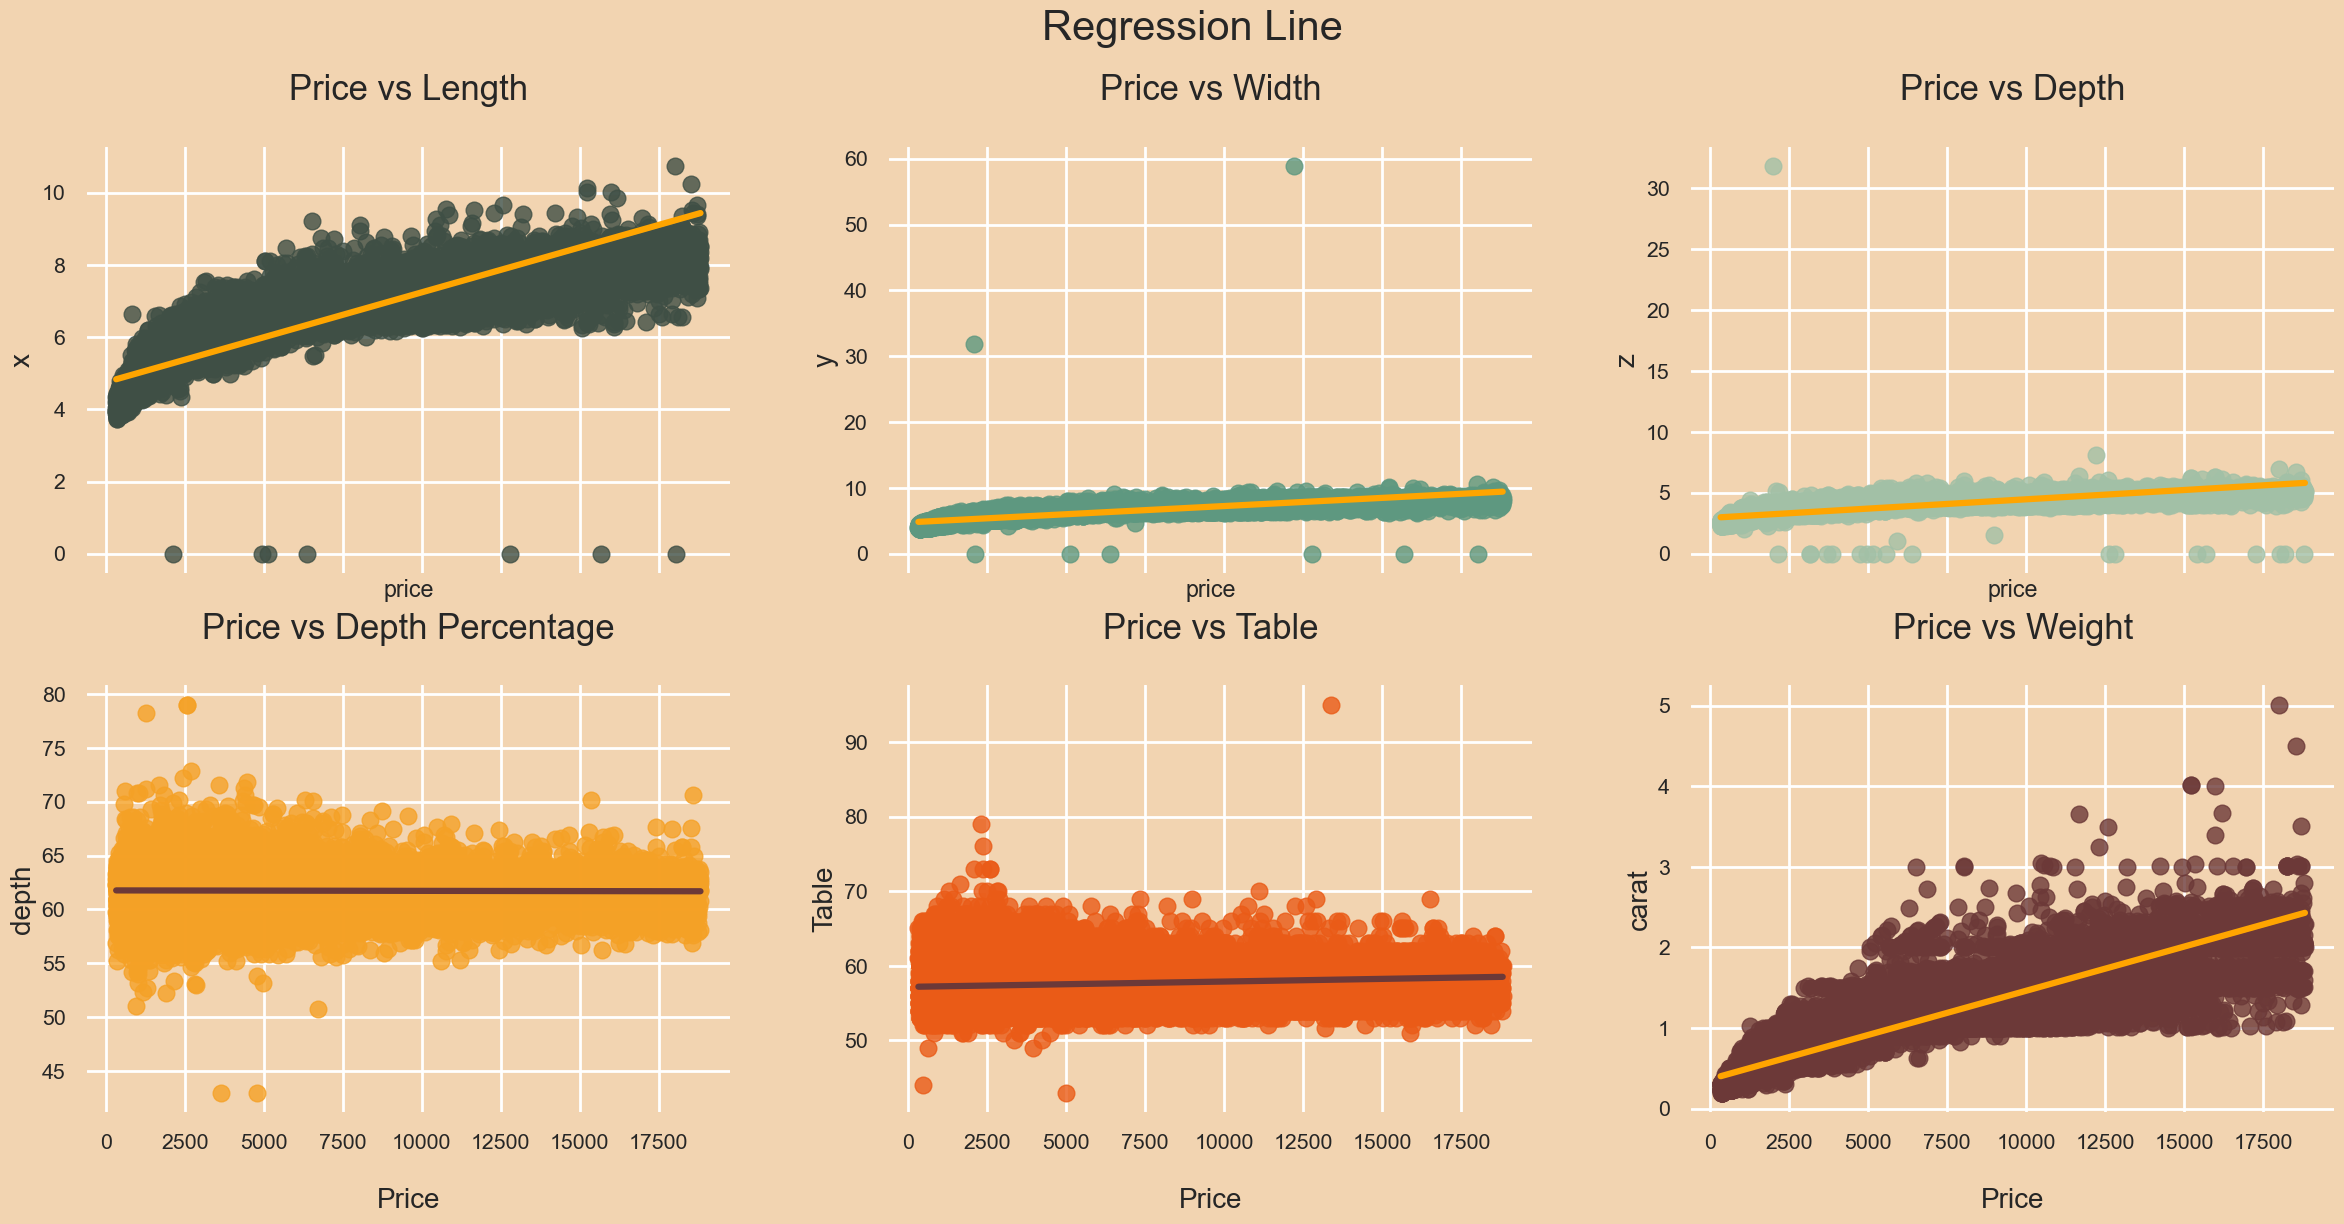

In [173]:
_, axs = plt.subplots(2,3,figsize=(25,12),sharex=True)
plt.tight_layout(pad=4.0)

sns.regplot(x="price", y="x", diamonds=diamonds, ax=axs[0,0], color="#3f4f45", fit_reg=True, line_kws=dict(color= "orange"))
axs[0,0].set_title("Price vs Length\n",fontsize=25)
axs[0,0].set_ylabel("x",fontsize=20)

sns.regplot(x="price", y="y", data=diamonds, ax=axs[0,1], color="#5e9880", fit_reg=True, line_kws=dict(color= "orange"))
axs[0,1].set_title("Price vs Width\n",fontsize=25)
axs[0,1].set_ylabel("y",fontsize=20)

sns.regplot(x="price", y="z", data=diamonds, ax=axs[0,2], color="#a2c0a6", fit_reg=True, line_kws=dict(color= "orange"))
axs[0,2].set_title("Price vs Depth\n",fontsize=25)
axs[0,2].set_ylabel("z",fontsize=20)

sns.regplot(x="price", y="depth", data=diamonds, ax=axs[1,0], color="#f5a126", fit_reg=True, line_kws=dict(color= "#6c3938"))
axs[1,0].set_title("Price vs Depth Percentage\n",fontsize=25)
axs[1,0].set_xlabel("\nPrice",fontsize=20)
axs[1,0].set_ylabel("depth",fontsize=20)

sns.regplot(x="price", y="table", data=diamonds, ax=axs[1,1], color="#ea5b17", fit_reg=True, line_kws=dict(color= "#6c3938"))
axs[1,1].set_title("Price vs Table\n",fontsize=25)
axs[1,1].set_xlabel("\nPrice",fontsize=20)
axs[1,1].set_ylabel("Table",fontsize=20)

sns.regplot(x="price", y="carat", data=diamonds, ax=axs[1,2], color="#6c3938", fit_reg=True, line_kws=dict(color= "orange"))
axs[1,2].set_title("Price vs Weight\n",fontsize=25)
axs[1,2].set_xlabel("\nPrice",fontsize=20)
axs[1,2].set_ylabel("carat",fontsize=20)

plt.suptitle("Regression Line",fontsize=30, y=1.03)
sns.despine(left=True, bottom=True)
plt.show()

In [286]:
# Manually removing the outliers

diamonds = diamonds[(diamonds["x"]<10)&(diamonds["x"]>3)]
diamonds = diamonds[(diamonds["y"]<13)&(diamonds["y"]>2)]
diamonds = diamonds[(diamonds["z"]<6)&(diamonds["z"]>2)]
diamonds = diamonds[(diamonds["depth"]<73)&(diamonds["depth"]>53)]
diamonds = diamonds[(diamonds["table"]<71)&(diamonds["table"]>50)]
diamonds = diamonds[(diamonds["carat"]<3)]

print(f"After dropping the outliers, let's have a look at the new pairwise relationships:")


After dropping the outliers, let's have a look at the new pairwise relationships:


In [184]:
sns.set()

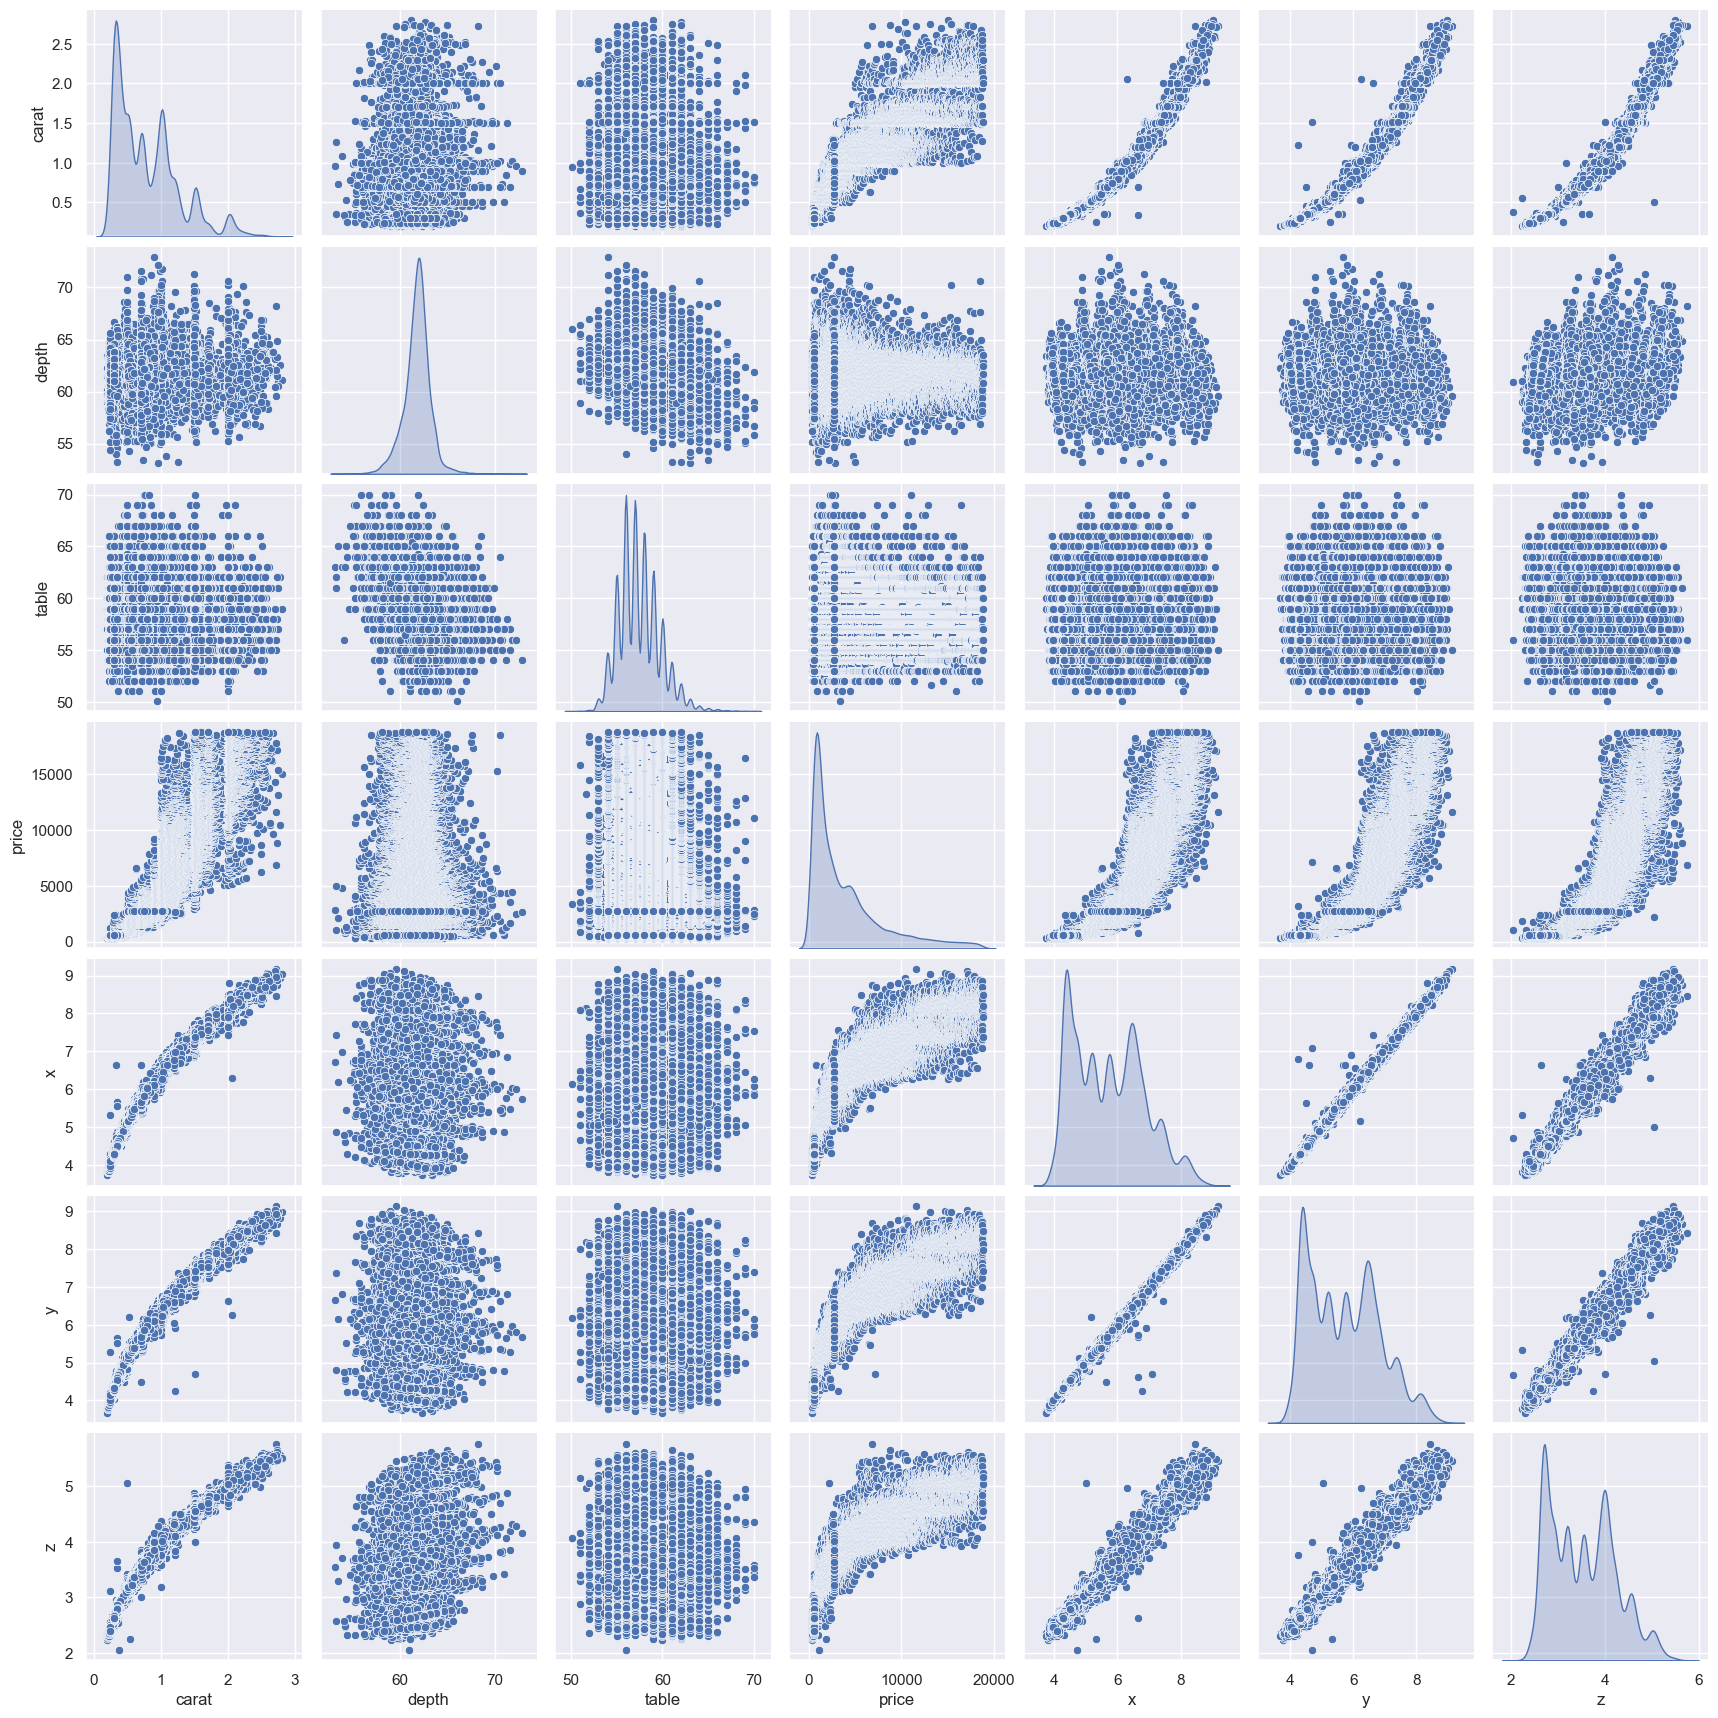

In [287]:
sns.pairplot(diamonds, diag_kind = 'kde')
plt.show()

<a id="14"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Correlation Map</p>

In [46]:
corr = diamonds.corr()
corr

carat     depth     table     price         x         y         z
carat  1.000000  0.027074  0.181688  0.922186  0.975152  0.949687  0.951824
depth  0.027074  1.000000 -0.297123 -0.012037 -0.025858 -0.029903  0.094344
table  0.181688 -0.297123  1.000000  0.127832  0.195367  0.183362  0.150646
price  0.922186 -0.012037  0.127832  1.000000  0.885019  0.864059  0.860247
x      0.975152 -0.025858  0.195367  0.885019  1.000000  0.972447  0.969336
y      0.949687 -0.029903  0.183362  0.864059  0.972447  1.000000  0.948768
z      0.951824  0.094344  0.150646  0.860247  0.969336  0.948768  1.000000

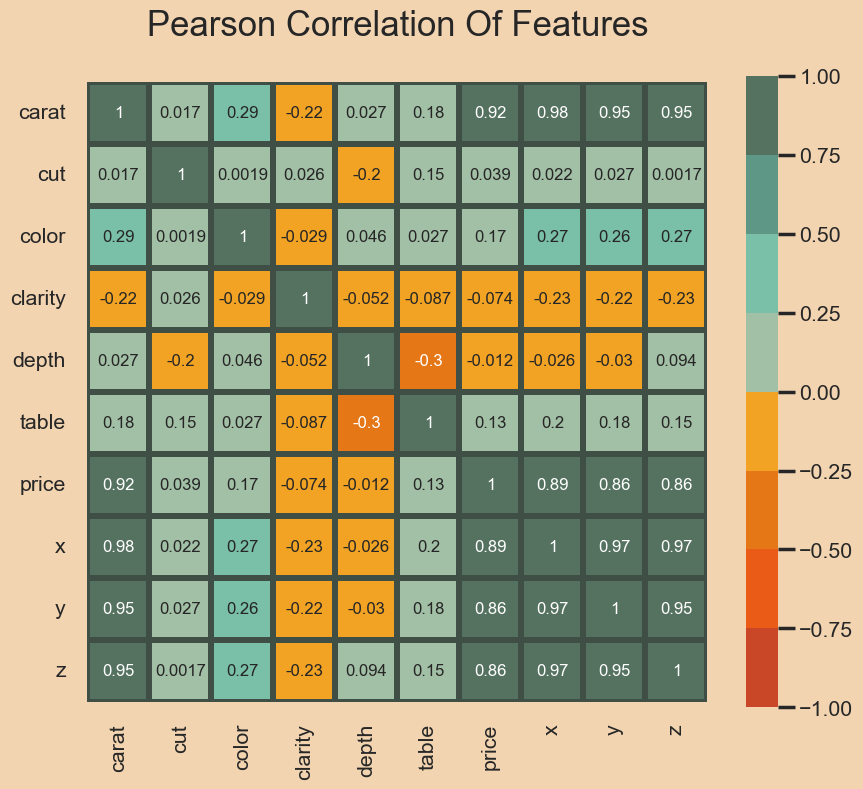

In [209]:
catcol = ["color","clarity","cut"]
le = LabelEncoder()
for col in catcol:
        diamonds[col] = le.fit_transform(diamonds[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(diamonds.corr(), cmap = palette, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#3f4f45',annot_kws=dict(fontsize =12))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

<a id="14"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">A Further Look</p>

### Correlation 'price' and 'carat'

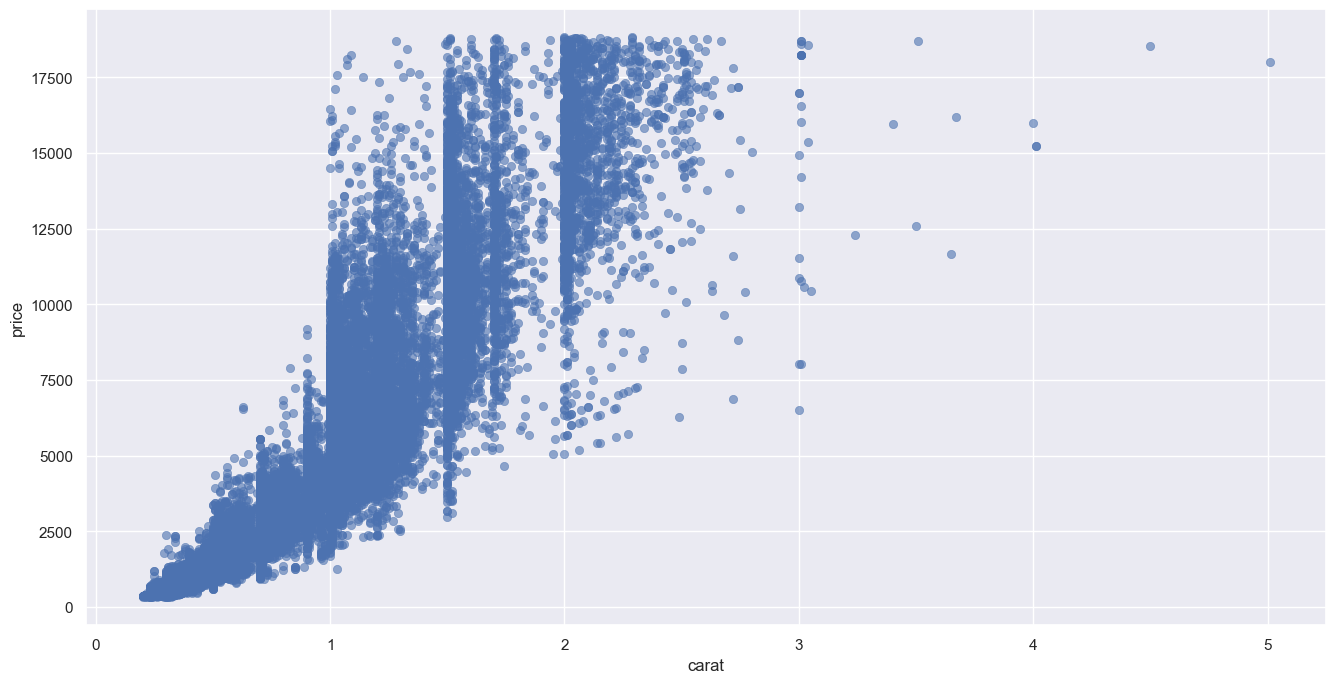

In [271]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=diamonds, x="carat", y="price", edgecolor=None, alpha=0.6);
plt.show()

### Let's now look at how this diagram varies by associating other features

- Correlation 'price' and 'carat' associated to 'color'

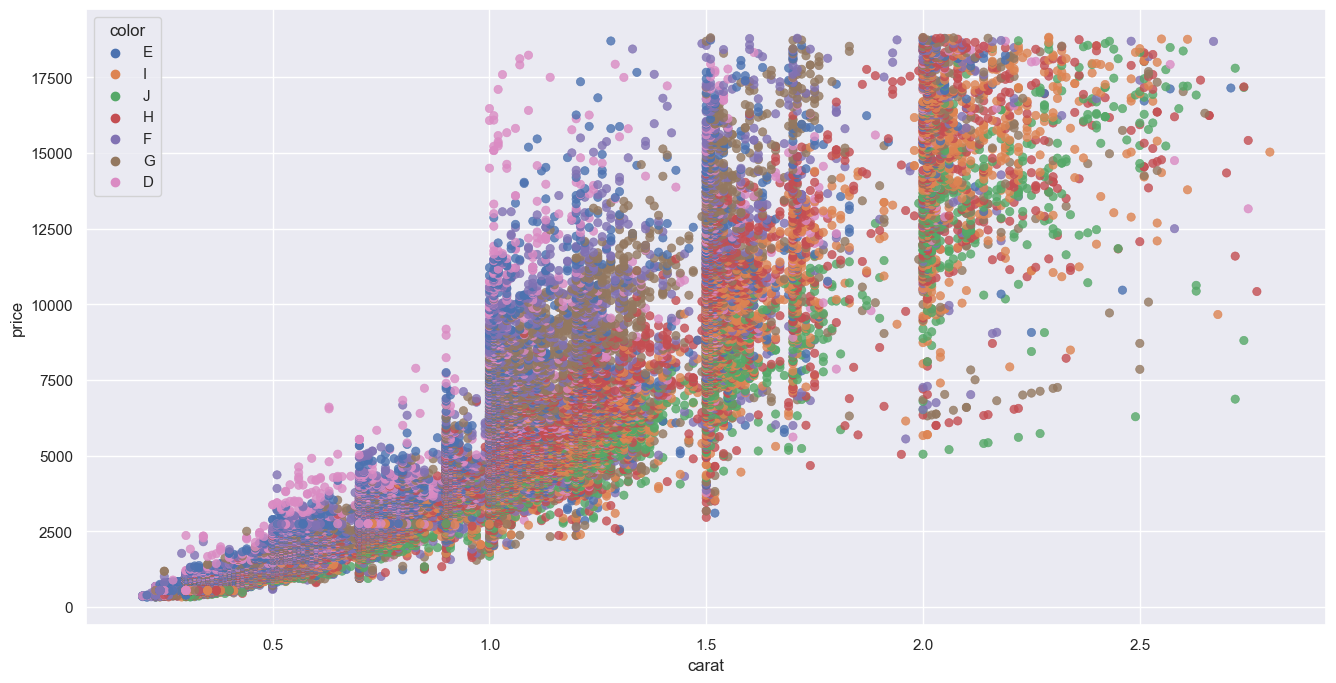

In [288]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=diamonds, x="carat", y="price", hue="color", edgecolor=None, alpha=0.8
)
plt.show()

- Correlation 'price' and 'carat' associated to 'clarity'

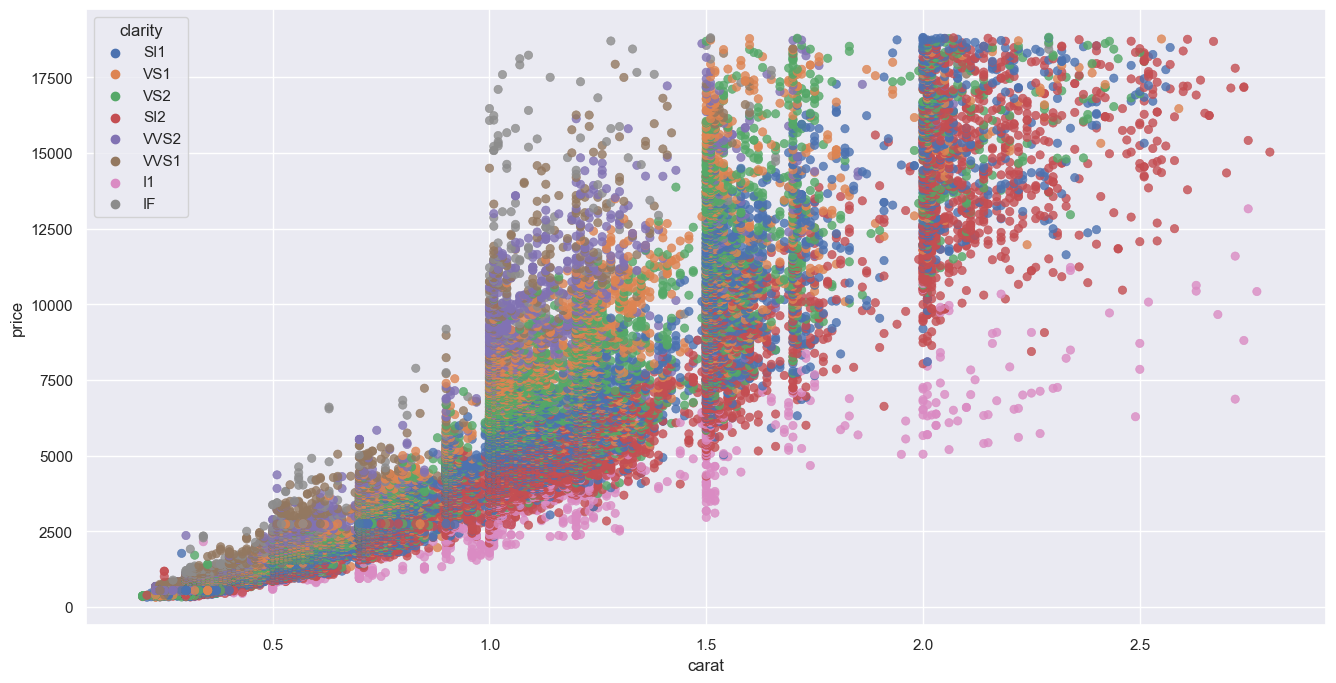

In [291]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=diamonds, x="carat", y="price", hue="clarity", edgecolor=None, alpha=0.8
)
plt.show()

- Correlation 'price' and 'carat' associated to 'cut'

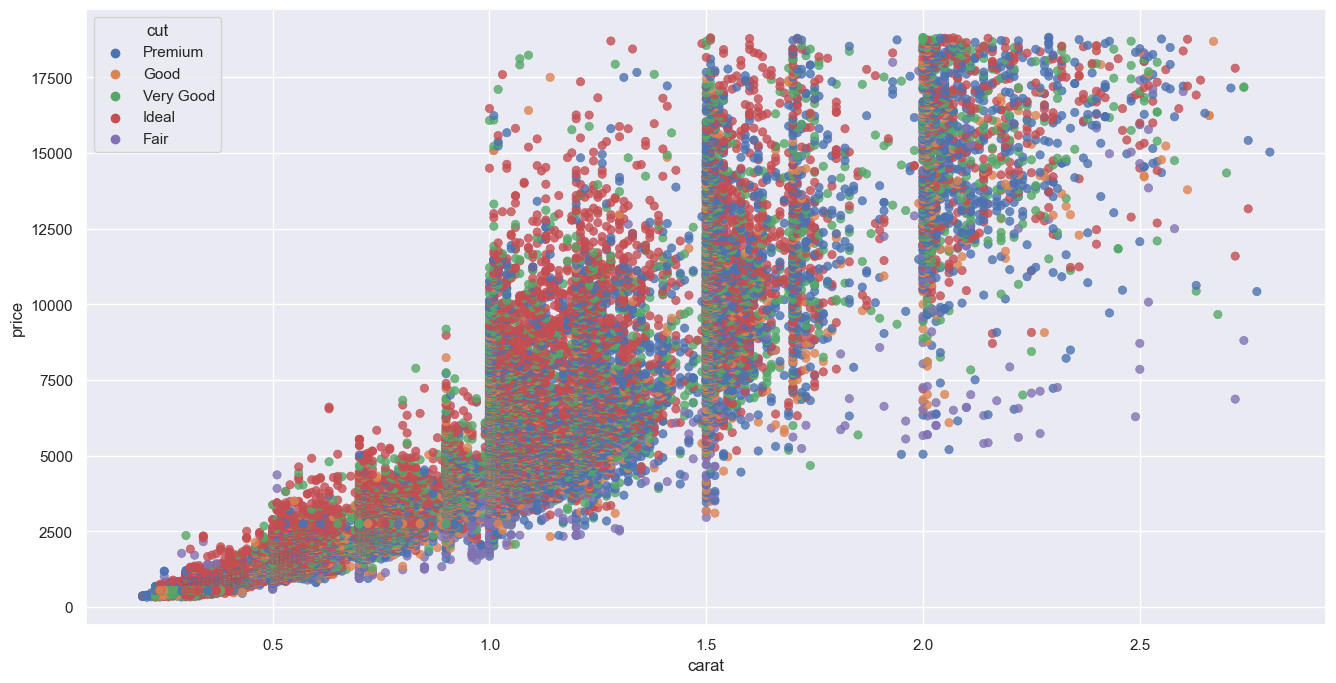

In [292]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=diamonds, x="carat", y="price", hue="cut", edgecolor=None, alpha=0.8
)
plt.show()

### Logarithmic base transformation

In [293]:
diamonds["carat_log"] = np.log(diamonds["carat"])
diamonds["price_log"] = np.log(diamonds["price"])
diamonds

carat        cut color clarity  depth  table  price     x     y     z  \
0       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
1       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
2       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
3       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   
4       0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48   
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...   
48917   0.72    Premium     D     SI1   62.7   59.0   2757  5.69  5.73  3.58   
48918   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50   
48919   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61   
48920   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56   
48921   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64   

       carat_log  price_log  
0      -1.560648   5.786897  
1      -1.469676   5.789960  
2      -1.237874   5.811141  
3      -1.171183   5.814131  
4      -1.427116   5.817111  
...          ...        ...  
48917  -0.328504   7.921898  
48918  -0.328504   7.921898  
48919  -0.328504   7.921898  
48920  -0.356675   7.921898  
48921  -0.287682   7.921898  

[48858 rows x 12 columns]

- Correlation 'price_log' and 'carat_log' associated to 'color'


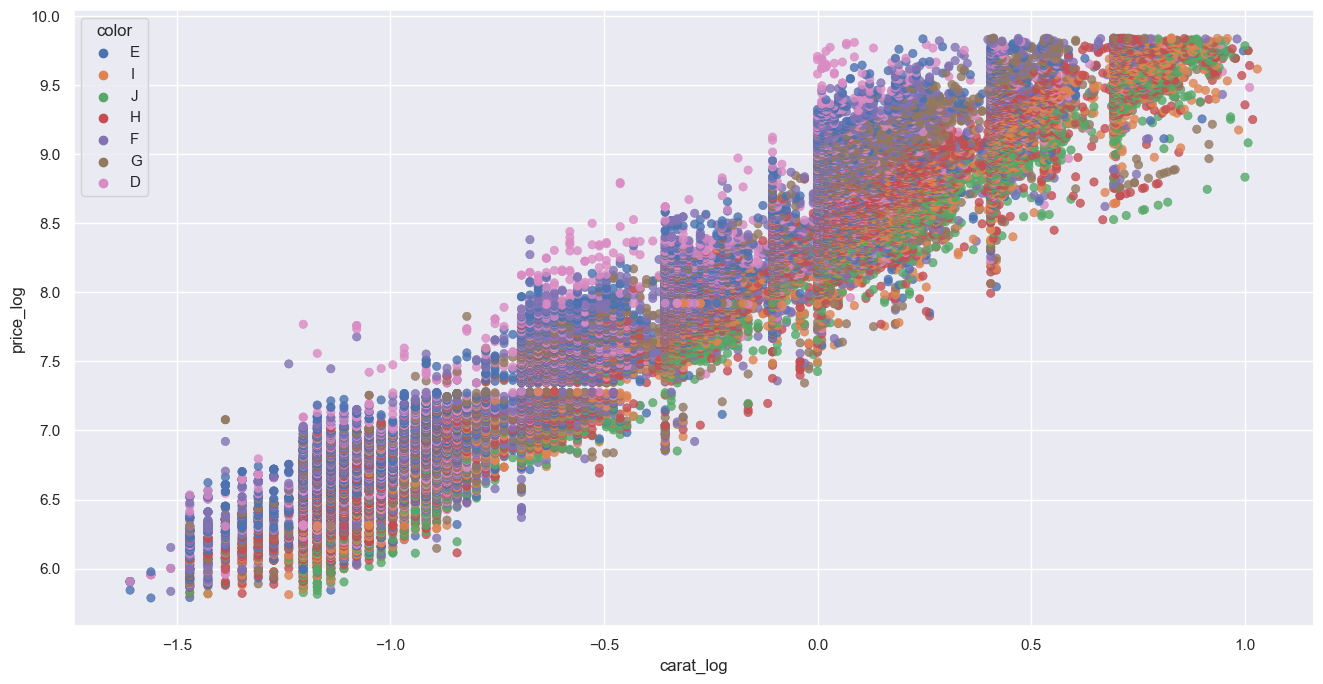

In [297]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=diamonds, x="carat_log", y="price_log", hue="color", edgecolor=None, alpha=0.8
)
plt.show()

- Correlation 'price_log' and 'carat_log' associated to 'clarity'


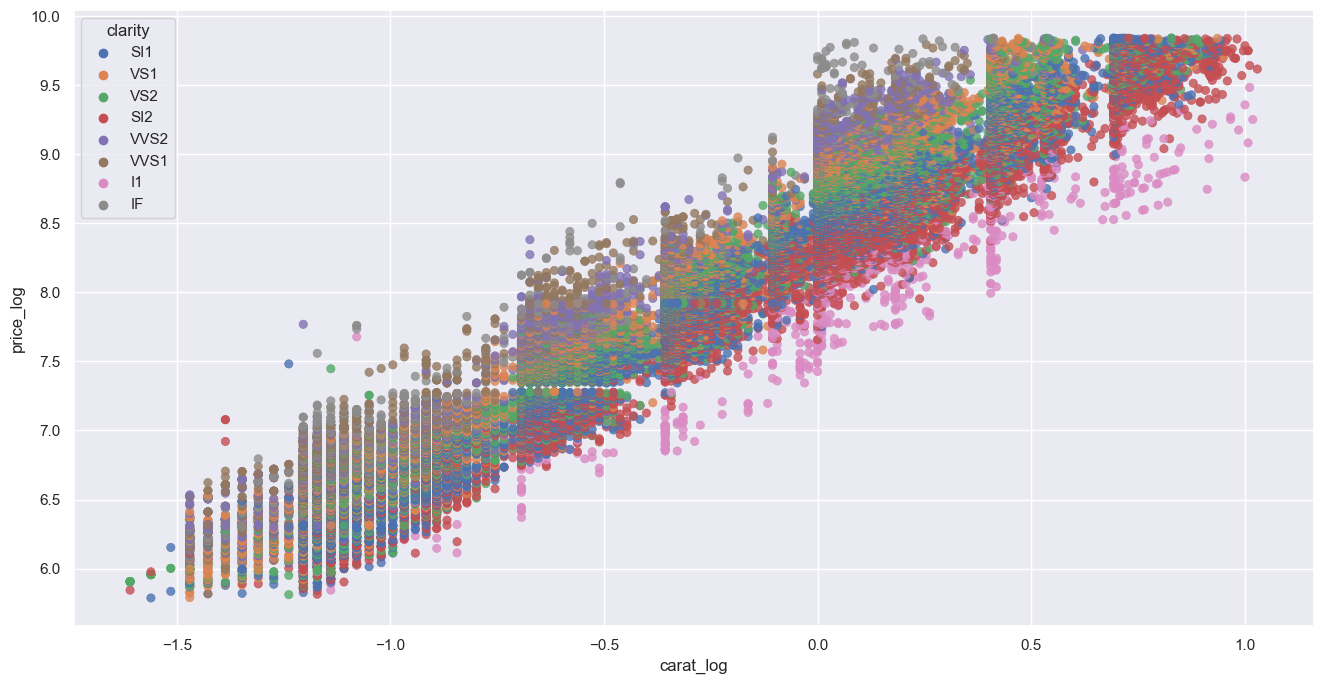

In [295]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=diamonds, x="carat_log", y="price_log", hue="clarity", edgecolor=None, alpha=0.8
)
plt.show()

- Correlation 'price_log' and 'carat_log' associated to 'cut'

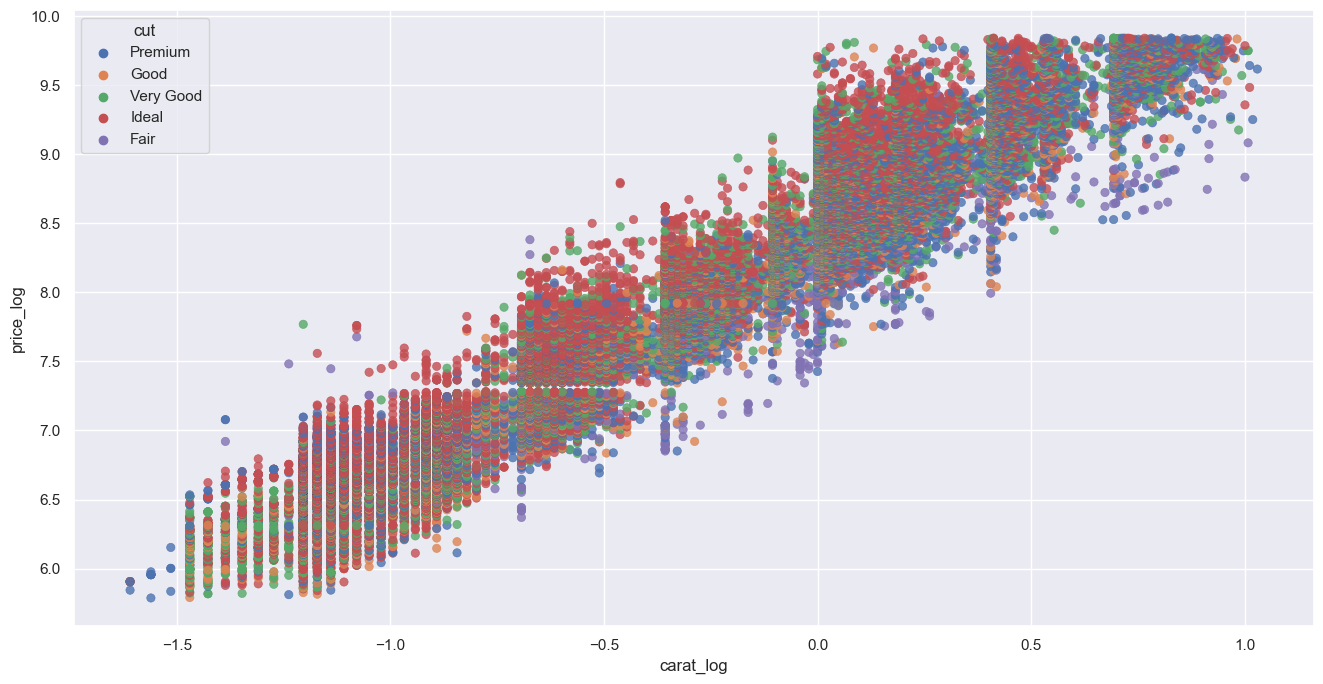

In [296]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=diamonds, x="carat_log", y="price_log", hue="cut", edgecolor=None, alpha=0.8
)
plt.show()

Creating dictionaries with numeric values for categories 'cut', 'color' and 'clarity'

In [298]:
# 'cut' quality range varies from 1 ('Fair') to 5 ('Ideal')
cut_quality = {"Fair": 1, "Good": 2, "Very Good": 3, "Premium": 4, "Ideal": 5}

# 'color' quality range varies from 1 ('J') to 7 ('D')
color_quality = {"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I": 2, "J": 1}

# 'clarity' quality range varies from 1 ('I1') to 7 ('IF')
clarity_quality = {
    "I1": 1,
    "SI2": 2,
    "SI1": 3,
    "VS2": 4,
    "VS1": 5,
    "VVS2": 5,
    "VVS1": 6,
    "IF": 7,
}

In [299]:
# Applying (here's a good opportunity to use lambda functions!)
diamonds["cut_quality"] = diamonds["cut"].apply(lambda x: cut_quality[x])
diamonds["color_quality"] = diamonds["color"].apply(lambda x: color_quality[x])
diamonds["clarity_quality"] = diamonds["clarity"].apply(lambda x: clarity_quality[x])
diamonds

carat        cut color clarity  depth  table  price     x     y     z  \
0       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
1       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
2       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
3       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   
4       0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48   
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...   
48917   0.72    Premium     D     SI1   62.7   59.0   2757  5.69  5.73  3.58   
48918   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50   
48919   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61   
48920   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56   
48921   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64   

       carat_log  price_log  cut_quality  color_quality  clarity_quality  
0      -1.560648   5.786897            4              6                3  
1      -1.469676   5.789960            2              6                5  
2      -1.237874   5.811141            4              2                4  
3      -1.171183   5.814131            2              1                2  
4      -1.427116   5.817111            3              1                5  
...          ...        ...          ...            ...              ...  
48917  -0.328504   7.921898            4              7                3  
48918  -0.328504   7.921898            5              7                3  
48919  -0.328504   7.921898            2              7                3  
48920  -0.356675   7.921898            3              7                3  
48921  -0.287682   7.921898            5              7                2  

[48858 rows x 15 columns]

<a id="15"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model Creation & Performance Evaluation</p>

After the standardization, we will split the dataset with a ratio of 0.2 i.e. 80% of data will be used for training and 20% for the validation process.

In [211]:
sc = StandardScaler()
x = diamonds.drop(["price"],axis =1) # price will be our target (y)
x = sc.fit_transform(x)
y = diamonds["price"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<center> <span style="font-family:newtimeroman"> <span style="padding:5px;color:white;display:fill;border-radius:20px 50px;background-color:#FDD667;font-size:200%;font-weight: 500;color:#111423;overflow:hidden;">ㅤLinear Regressionㅤ</span>

In [212]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

print("After performing the Linear Regression with SKLearn,\n")
print(f"R Squared Value: {metrics.r2_score(y_test,y_pred)}")
print(f"Adjusted R Squared Value: {1-(1-metrics.r2_score(y_test,y_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}")
print(f"Mean Absolute Error: {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred)}")
print(f"Root Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred,squared = False)}")

After performing the Linear Regression with SKLearn,

R Squared Value: 0.8885407086951569
Adjusted R Squared Value: 0.8884381178154531
Mean Absolute Error: 844.8370225588242
Mean Squared Error: 1733016.3581049452
Root Mean Squared Error: 1316.4407917202145


In [ ]:
sc = StandardScaler()
x = diamonds.drop(["price"],axis =1) # price will be our target (y)
x = sc.fit_transform(x)
y = diamonds["price"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [250]:
sns.set()

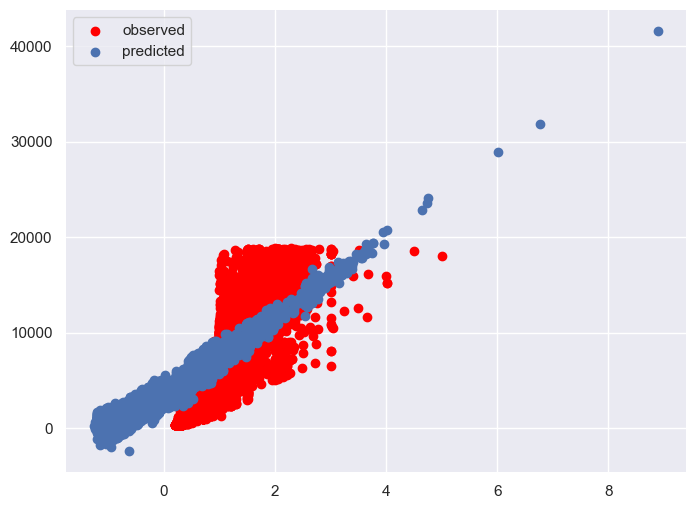

In [259]:
plt.figure(figsize=(8,6))
# plt.xlabel('price')
# plt.ylabel('carat')
plt.scatter(diamonds['carat'], y, color='red', label='observed')
sns.despine(left=True, bottom=True)
# plot the predicted values together with the observed values
plt.scatter(x_test[:,0], y_pred, label='predicted')

plt.legend()
plt.show()

<center> <span style="font-family:newtimeroman"> <span style="padding:5px;color:white;display:fill;border-radius:20px 50px;background-color:#FDD667;font-size:200%;font-weight: 500;color:#111423;overflow:hidden;">ㅤDecision Tree Regressionㅤ</span>

In [201]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)

print("After Performing Decision Tree Regression,\n")
print(f"R Squared Value: {metrics.r2_score(y_test,y_pred)}")
print(f"Adjusted R Squared Value: {1-(1-metrics.r2_score(y_test,y_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}")
print(f"Mean Absolute Error: {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred)}")
print(f"Root Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred,squared = False)}")

After Performing Decision Tree Regression,

R Squared Value: 0.9640975493985238
Adjusted R Squared Value: 0.9640645035757162
Mean Absolute Error: 364.3079280751941
Mean Squared Error: 558226.5368818962
Root Mean Squared Error: 747.1455928277273


<center> <span style="font-family:newtimeroman"> <span style="padding:5px;color:white;display:fill;border-radius:20px 50px;background-color:#FDD667;font-size:200%;font-weight: 500;color:#111423;overflow:hidden;">ㅤRandom Forest Regressionㅤ</span>

In [202]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

print("After Performing Random Forest Regression,\n")
print(f"R Squared Value: {metrics.r2_score(y_test,y_pred)}")
print(f"Adjusted R Squared Value: {1-(1-metrics.r2_score(y_test,y_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}")
print(f"Mean Absolute Error: {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred)}")
print(f"Root Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred,squared = False)}")

After Performing Random Forest Regression,

R Squared Value: 0.9805862653291031
Adjusted R Squared Value: 0.9805683962748959
Mean Absolute Error: 269.82116456983283
Mean Squared Error: 301852.9847328354
Root Mean Squared Error: 549.4114894437823


<center> <span style="font-family:newtimeroman"> <span style="padding:5px;color:white;display:fill;border-radius:20px 50px;background-color:#FDD667;font-size:200%;font-weight: 500;color:#111423;overflow:hidden;">ㅤK-Neighbors Regressionㅤ</span>

In [203]:
kn = KNeighborsRegressor()
kn.fit(x_train,y_train)
y_pred = kn.predict(x_test)

print("After Performing K-Neighbors Regression,\n")
print(f"R Squared Value: {metrics.r2_score(y_test,y_pred)}")
print(f"Adjusted R Squared Value: {1-(1-metrics.r2_score(y_test,y_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}")
print(f"Mean Absolute Error: {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred)}")
print(f"Root Mean Squared Error: {metrics.mean_squared_error(y_test,y_pred,squared = False)}")

After Performing K-Neighbors Regression,

R Squared Value: 0.9599407056786297
Adjusted R Squared Value: 0.9599038337570821
Mean Absolute Error: 402.15884756845116
Mean Squared Error: 622858.906963629
Root Mean Squared Error: 789.2141071747444


In [303]:
x_train.shape

(39152, 9)

In [304]:
x_test.shape

(9788, 9)

This first analysis indicates that a Random Forest Regressor might yield better results with this type of dataset. Now we can test it with Rick's diamonds.

In [307]:
x_train

array([[-1.07107048, -1.51099939, -0.34870701, ..., -1.21285419,
        -1.16501894, -1.4836359 ],
       [ 0.44753008,  1.41078085, -0.34870701, ...,  0.49851473,
         0.44150214,  0.62442901],
       [-0.62814532, -1.51099939, -0.34870701, ..., -0.37499649,
        -0.44906933, -0.80452774],
       ...,
       [-0.79687872, -0.53707264, -0.93699757, ..., -0.78501196,
        -0.80704413, -0.81867583],
       [-0.62814532, -0.53707264, -0.93699757, ..., -0.58000423,
        -0.53638025, -0.52156601],
       [ 1.08028031, -0.53707264,  1.41616469, ...,  1.2204985 ,
         1.10506519,  1.14790822]])

In [210]:
rick_diamonds = pd.read_csv('rick_diamonds.csv')

<a id="16"></a>
# <p style="padding:10px;background-color:#0fa79f;margin:0;color:#111423;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Thank You</p>

<p>
<br>

<h4><b>Author :</b></h4>

<h3>Henrique Batistuzzo</h3>

<b>👉Shoot me mails :</b> hbatistuzzo@gmail.com<br>
<b>👉Connect on LinkedIn :</b> https://www.linkedin.com/in/hbatistuzzo <br>
<b>👉Explore Github :</b> https://github.com/hbatistuzzo    
    
</p> 

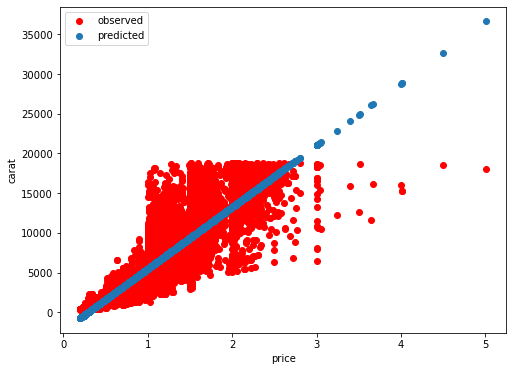

In [18]:
plt.figure(figsize=(8,6))
plt.xlabel('price')
plt.ylabel('carat')
plt.scatter(X, y, color='red', label='observed')

# plot the predicted values together with the observed values
plt.scatter(X_all, y_predicted_all, label='predicted')


plt.legend();

In [19]:
model.coef_

array([7759.35277644])

In [20]:
model.intercept_

-2256.1316930738426

In [21]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, y_predicted_all)

2380375.235074832

In [23]:
diamonds['price'].mean()

3934.409644462607

In [25]:
diamonds

carat        cut color clarity  depth  table  price     x     y     z
0       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
1       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
2       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
3       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
4       0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
48935   0.72    Premium     D     SI1   62.7   59.0   2757  5.69  5.73  3.58
48936   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
48937   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
48938   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
48939   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[48940 rows x 10 columns]

In [6]:
rick_diamonds = pd.read_csv('rick_diamonds.csv')

In [34]:
X_rick = rick_diamonds[['carat']]
y_predicted_rick = model.predict(X_rick)

In [33]:
X_rick

carat
0      0.91
1      0.38
2      0.52
3      1.10
4      2.28
...     ...
4995   0.30
4996   0.51
4997   1.01
4998   0.31
4999   0.33

[5000 rows x 1 columns]

In [35]:
y_predicted_rick

array([4804.87933349,  692.42236197, 1778.73175068, ..., 5580.81461113,
        149.26766762,  304.45472315])

In [36]:
rick_diamonds['price_predicted'] = y_predicted_rick

In [39]:
rick_diamonds.to_csv('rick_diamonds_pred.csv')

In [53]:
mean_squared_error(y, y_predicted_rick)

ValueError: Found input variables with inconsistent numbers of samples: [48940, 5000]

Lets, uhhh, redo a first model based on the mean to see what happens

In [ ]:
model = LinearRegression()

In [62]:
rick_diamonds = pd.read_csv('rick_diamonds.csv')
rick_diamonds

carat        cut color clarity  depth  table     x     y     z
0      0.91  Very Good     H     SI2   63.4   57.0  6.10  6.18  3.89
1      0.38       Good     F     VS2   60.3   61.0  4.68  4.71  2.83
2      0.52      Ideal     H     VS2   61.8   56.0  5.19  5.16  3.20
3      1.10      Ideal     G     VS1   61.3   56.0  6.65  6.69  4.09
4      2.28      Ideal     G     SI2   61.6   57.0  8.44  8.37  5.18
...     ...        ...   ...     ...    ...    ...   ...   ...   ...
4995   0.30  Very Good     D     SI2   62.2   59.0  4.25  4.30  2.66
4996   0.51      Ideal     F    VVS2   61.9   56.0  5.09  5.14  3.16
4997   1.01  Very Good     F     SI1   60.6   60.0  6.37  6.43  3.88
4998   0.31      Ideal     F    VVS1   62.1   56.0  4.35  4.38  2.71
4999   0.33      Ideal     E     VS2   61.8   55.0  4.45  4.48  2.76

[5000 rows x 9 columns]

In [59]:
mean_price = diamonds['price'].mean()
mean_price

3934.409644462607

In [63]:
 rick_diamonds['price_predicted'] = 3934.409644462607

In [66]:
 rick_diamonds.to_csv('rick_diamonds_mean.csv')

DATA TRANSFORMATION

In [7]:
diamonds_new = diamonds
diamonds_new.loc[diamonds['cut'] == 'Fair','cut'] = 1
diamonds_new.loc[diamonds['cut'] == 'Good','cut'] = 2
diamonds_new.loc[diamonds['cut'] == 'Very Good','cut'] = 3
diamonds_new.loc[diamonds['cut'] == 'Premium','cut'] = 4
diamonds_new.loc[diamonds['cut'] == 'Ideal','cut'] = 5

In [73]:
diamonds_new

carat cut color clarity  depth  table  price     x     y     z
0       0.21   4     E     SI1   59.8   61.0    326  3.89  3.84  2.31
1       0.23   2     E     VS1   56.9   65.0    327  4.05  4.07  2.31
2       0.29   4     I     VS2   62.4   58.0    334  4.20  4.23  2.63
3       0.31   2     J     SI2   63.3   58.0    335  4.34  4.35  2.75
4       0.24   3     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
...      ...  ..   ...     ...    ...    ...    ...   ...   ...   ...
48935   0.72   4     D     SI1   62.7   59.0   2757  5.69  5.73  3.58
48936   0.72   5     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
48937   0.72   2     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
48938   0.70   3     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
48939   0.75   5     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[48940 rows x 10 columns]

NEW MODEL BASED ON CUTS

In [87]:
X = diamonds_new[['carat','cut']]
y = diamonds_new['price']

In [88]:
diamonds_new[['carat','cut']]

carat cut
0       0.21   4
1       0.23   2
2       0.29   4
3       0.31   2
4       0.24   3
...      ...  ..
48935   0.72   4
48936   0.72   5
48937   0.72   2
48938   0.70   3
48939   0.75   5

[48940 rows x 2 columns]

In [89]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [92]:
rick_diamonds = pd.read_csv('rick_diamonds.csv')
rick_diamonds

carat        cut color clarity  depth  table     x     y     z
0      0.91  Very Good     H     SI2   63.4   57.0  6.10  6.18  3.89
1      0.38       Good     F     VS2   60.3   61.0  4.68  4.71  2.83
2      0.52      Ideal     H     VS2   61.8   56.0  5.19  5.16  3.20
3      1.10      Ideal     G     VS1   61.3   56.0  6.65  6.69  4.09
4      2.28      Ideal     G     SI2   61.6   57.0  8.44  8.37  5.18
...     ...        ...   ...     ...    ...    ...   ...   ...   ...
4995   0.30  Very Good     D     SI2   62.2   59.0  4.25  4.30  2.66
4996   0.51      Ideal     F    VVS2   61.9   56.0  5.09  5.14  3.16
4997   1.01  Very Good     F     SI1   60.6   60.0  6.37  6.43  3.88
4998   0.31      Ideal     F    VVS1   62.1   56.0  4.35  4.38  2.71
4999   0.33      Ideal     E     VS2   61.8   55.0  4.45  4.48  2.76

[5000 rows x 9 columns]

In [98]:
rick_diamonds.loc[rick_diamonds['cut'] == 'Good','cut'] = 2
rick_diamonds.loc[rick_diamonds['cut'] == 'Very Good','cut'] = 3
rick_diamonds.loc[rick_diamonds['cut'] == 'Fair','cut'] = 1
rick_diamonds.loc[rick_diamonds['cut'] == 'Premium','cut'] = 4
rick_diamonds.loc[rick_diamonds['cut'] == 'Ideal','cut'] = 5

In [99]:
y_predicted_rick = model.predict(rick_diamonds[['carat','cut']])

In [101]:
rick_diamonds['price_predicted'] = y_predicted_rick

In [102]:
rick_diamonds

carat cut color clarity  depth  table     x     y     z  price_predicted
0      0.91   3     H     SI2   63.4   57.0  6.10  6.18  3.89      4581.585873
1      0.38   2     F     VS2   60.3   61.0  4.68  4.71  2.83       168.980019
2      0.52   5     H     VS2   61.8   56.0  5.19  5.16  3.20      2036.409252
3      1.10   5     G     VS1   61.3   56.0  6.65  6.69  4.09      6584.564584
4      2.28   5     G     SI2   61.6   57.0  8.44  8.37  5.18     15837.708191
...     ...  ..   ...     ...    ...    ...   ...   ...   ...              ...
4995   0.30   3     D     SI2   62.2   59.0  4.25  4.30  2.66      -201.818873
4996   0.51   5     F    VVS2   61.9   56.0  5.09  5.14  3.16      1957.992780
4997   1.01   3     F     SI1   60.6   60.0  6.37  6.43  3.88      5365.750586
4998   0.31   5     F    VVS1   62.1   56.0  4.35  4.38  2.71       389.663356
4999   0.33   5     E     VS2   61.8   55.0  4.45  4.48  2.76       546.496298

[5000 rows x 10 columns]

In [103]:
rick_diamonds.to_csv('rick_diamonds_pred.csv')

Now with clarity

In [11]:
rick_diamonds

carat cut color clarity  depth  table     x     y     z
0      0.91   3     H     SI2   63.4   57.0  6.10  6.18  3.89
1      0.38   2     F     VS2   60.3   61.0  4.68  4.71  2.83
2      0.52   5     H     VS2   61.8   56.0  5.19  5.16  3.20
3      1.10   5     G     VS1   61.3   56.0  6.65  6.69  4.09
4      2.28   5     G     SI2   61.6   57.0  8.44  8.37  5.18
...     ...  ..   ...     ...    ...    ...   ...   ...   ...
4995   0.30   3     D     SI2   62.2   59.0  4.25  4.30  2.66
4996   0.51   5     F    VVS2   61.9   56.0  5.09  5.14  3.16
4997   1.01   3     F     SI1   60.6   60.0  6.37  6.43  3.88
4998   0.31   5     F    VVS1   62.1   56.0  4.35  4.38  2.71
4999   0.33   5     E     VS2   61.8   55.0  4.45  4.48  2.76

[5000 rows x 9 columns]

In [10]:
rick_diamonds.loc[rick_diamonds['cut'] == 'Good','cut'] = 2
rick_diamonds.loc[rick_diamonds['cut'] == 'Very Good','cut'] = 3
rick_diamonds.loc[rick_diamonds['cut'] == 'Fair','cut'] = 1
rick_diamonds.loc[rick_diamonds['cut'] == 'Premium','cut'] = 4
rick_diamonds.loc[rick_diamonds['cut'] == 'Ideal','cut'] = 5

In [12]:
rick_diamonds

carat cut color clarity  depth  table     x     y     z
0      0.91   3     H     SI2   63.4   57.0  6.10  6.18  3.89
1      0.38   2     F     VS2   60.3   61.0  4.68  4.71  2.83
2      0.52   5     H     VS2   61.8   56.0  5.19  5.16  3.20
3      1.10   5     G     VS1   61.3   56.0  6.65  6.69  4.09
4      2.28   5     G     SI2   61.6   57.0  8.44  8.37  5.18
...     ...  ..   ...     ...    ...    ...   ...   ...   ...
4995   0.30   3     D     SI2   62.2   59.0  4.25  4.30  2.66
4996   0.51   5     F    VVS2   61.9   56.0  5.09  5.14  3.16
4997   1.01   3     F     SI1   60.6   60.0  6.37  6.43  3.88
4998   0.31   5     F    VVS1   62.1   56.0  4.35  4.38  2.71
4999   0.33   5     E     VS2   61.8   55.0  4.45  4.48  2.76

[5000 rows x 9 columns]

In [8]:
diamonds_new.loc[diamonds['cut'] == 'Fair','cut'] = 1
diamonds_new.loc[diamonds['cut'] == 'Good','cut'] = 2
diamonds_new.loc[diamonds['cut'] == 'Very Good','cut'] = 3
diamonds_new.loc[diamonds['cut'] == 'Premium','cut'] = 4
diamonds_new.loc[diamonds['cut'] == 'Ideal','cut'] = 5

carat cut color clarity  depth  table  price     x     y     z
0       0.21   4     E     SI1   59.8   61.0    326  3.89  3.84  2.31
1       0.23   2     E     VS1   56.9   65.0    327  4.05  4.07  2.31
2       0.29   4     I     VS2   62.4   58.0    334  4.20  4.23  2.63
3       0.31   2     J     SI2   63.3   58.0    335  4.34  4.35  2.75
4       0.24   3     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
...      ...  ..   ...     ...    ...    ...    ...   ...   ...   ...
48935   0.72   4     D     SI1   62.7   59.0   2757  5.69  5.73  3.58
48936   0.72   5     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
48937   0.72   2     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
48938   0.70   3     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
48939   0.75   5     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[48940 rows x 10 columns]

In [13]:
diamonds_new

carat cut color clarity  depth  table  price     x     y     z
0       0.21   4     E     SI1   59.8   61.0    326  3.89  3.84  2.31
1       0.23   2     E     VS1   56.9   65.0    327  4.05  4.07  2.31
2       0.29   4     I     VS2   62.4   58.0    334  4.20  4.23  2.63
3       0.31   2     J     SI2   63.3   58.0    335  4.34  4.35  2.75
4       0.24   3     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
...      ...  ..   ...     ...    ...    ...    ...   ...   ...   ...
48935   0.72   4     D     SI1   62.7   59.0   2757  5.69  5.73  3.58
48936   0.72   5     D     SI1   60.8   57.0   2757  5.75  5.76  3.50
48937   0.72   2     D     SI1   63.1   55.0   2757  5.69  5.75  3.61
48938   0.70   3     D     SI1   62.8   60.0   2757  5.66  5.68  3.56
48939   0.75   5     D     SI2   62.2   55.0   2757  5.83  5.87  3.64

[48940 rows x 10 columns]

In [14]:
diamonds_new.loc[diamonds['color'] == 'J','color'] = 1
diamonds_new.loc[diamonds['color'] == 'I','color'] = 2
diamonds_new.loc[diamonds['color'] == 'H','color'] = 3
diamonds_new.loc[diamonds['color'] == 'G','color'] = 4
diamonds_new.loc[diamonds['color'] == 'F','color'] = 5
diamonds_new.loc[diamonds['color'] == 'E','color'] = 6
diamonds_new.loc[diamonds['color'] == 'D','color'] = 7

In [18]:
diamonds_new

carat cut color clarity  depth  table  price     x     y     z
0       0.21   4     6     SI1   59.8   61.0    326  3.89  3.84  2.31
1       0.23   2     6     VS1   56.9   65.0    327  4.05  4.07  2.31
2       0.29   4     2     VS2   62.4   58.0    334  4.20  4.23  2.63
3       0.31   2     1     SI2   63.3   58.0    335  4.34  4.35  2.75
4       0.24   3     1    VVS2   62.8   57.0    336  3.94  3.96  2.48
...      ...  ..   ...     ...    ...    ...    ...   ...   ...   ...
48935   0.72   4     7     SI1   62.7   59.0   2757  5.69  5.73  3.58
48936   0.72   5     7     SI1   60.8   57.0   2757  5.75  5.76  3.50
48937   0.72   2     7     SI1   63.1   55.0   2757  5.69  5.75  3.61
48938   0.70   3     7     SI1   62.8   60.0   2757  5.66  5.68  3.56
48939   0.75   5     7     SI2   62.2   55.0   2757  5.83  5.87  3.64

[48940 rows x 10 columns]

In [19]:
rick_diamonds.loc[rick_diamonds['color'] == 'J','color'] = 1
rick_diamonds.loc[rick_diamonds['color'] == 'I','color'] = 2
rick_diamonds.loc[rick_diamonds['color'] == 'H','color'] = 3
rick_diamonds.loc[rick_diamonds['color'] == 'G','color'] = 4
rick_diamonds.loc[rick_diamonds['color'] == 'F','color'] = 5
rick_diamonds.loc[rick_diamonds['color'] == 'E','color'] = 6
rick_diamonds.loc[rick_diamonds['color'] == 'D','color'] = 7

In [20]:
rick_diamonds

carat cut color clarity  depth  table     x     y     z
0      0.91   3     3     SI2   63.4   57.0  6.10  6.18  3.89
1      0.38   2     5     VS2   60.3   61.0  4.68  4.71  2.83
2      0.52   5     3     VS2   61.8   56.0  5.19  5.16  3.20
3      1.10   5     4     VS1   61.3   56.0  6.65  6.69  4.09
4      2.28   5     4     SI2   61.6   57.0  8.44  8.37  5.18
...     ...  ..   ...     ...    ...    ...   ...   ...   ...
4995   0.30   3     7     SI2   62.2   59.0  4.25  4.30  2.66
4996   0.51   5     5    VVS2   61.9   56.0  5.09  5.14  3.16
4997   1.01   3     5     SI1   60.6   60.0  6.37  6.43  3.88
4998   0.31   5     5    VVS1   62.1   56.0  4.35  4.38  2.71
4999   0.33   5     6     VS2   61.8   55.0  4.45  4.48  2.76

[5000 rows x 9 columns]

In [21]:
diamonds_new.loc[diamonds['clarity'] == 'I1','clarity'] = 1
diamonds_new.loc[diamonds['clarity'] == 'SI2','clarity'] = 2
diamonds_new.loc[diamonds['clarity'] == 'SI1','clarity'] = 3
diamonds_new.loc[diamonds['clarity'] == 'VS2','clarity'] = 4
diamonds_new.loc[diamonds['clarity'] == 'VS1','clarity'] = 5
diamonds_new.loc[diamonds['clarity'] == 'VVS2','clarity'] = 6
diamonds_new.loc[diamonds['clarity'] == 'VVS1','clarity'] = 7
diamonds_new.loc[diamonds['clarity'] == 'IF','clarity'] = 8

In [25]:
rick_diamonds.loc[rick_diamonds['clarity'] == 'I1','clarity'] = 1
rick_diamonds.loc[rick_diamonds['clarity'] == 'SI2','clarity'] = 2
rick_diamonds.loc[rick_diamonds['clarity'] == 'SI1','clarity'] = 3
rick_diamonds.loc[rick_diamonds['clarity'] == 'VS2','clarity'] = 4
rick_diamonds.loc[rick_diamonds['clarity'] == 'VS1','clarity'] = 5
rick_diamonds.loc[rick_diamonds['clarity'] == 'VVS2','clarity'] = 6
rick_diamonds.loc[rick_diamonds['clarity'] == 'VVS1','clarity'] = 7
rick_diamonds.loc[rick_diamonds['clarity'] == 'IF','clarity'] = 8

In [27]:
rick_diamonds

carat cut color clarity  depth  table     x     y     z
0      0.91   3     3       2   63.4   57.0  6.10  6.18  3.89
1      0.38   2     5       4   60.3   61.0  4.68  4.71  2.83
2      0.52   5     3       4   61.8   56.0  5.19  5.16  3.20
3      1.10   5     4       5   61.3   56.0  6.65  6.69  4.09
4      2.28   5     4       2   61.6   57.0  8.44  8.37  5.18
...     ...  ..   ...     ...    ...    ...   ...   ...   ...
4995   0.30   3     7       2   62.2   59.0  4.25  4.30  2.66
4996   0.51   5     5       6   61.9   56.0  5.09  5.14  3.16
4997   1.01   3     5       3   60.6   60.0  6.37  6.43  3.88
4998   0.31   5     5       7   62.1   56.0  4.35  4.38  2.71
4999   0.33   5     6       4   61.8   55.0  4.45  4.48  2.76

[5000 rows x 9 columns]

In [28]:
rick_diamonds.to_csv('rick_diamonds_updated')

In [29]:
diamonds_new.to_csv('diamonds_new_updated')

Ok lets restart it all

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [31]:
X = diamonds_new[['carat','cut','color','clarity']]
y = diamonds_new['price']

model.fit(X,y)

y_predicted_rick = model.predict(rick_diamonds[['carat','cut','color','clarity']])


In [32]:
rick_diamonds

carat cut color clarity  depth  table     x     y     z
0      0.91   3     3       2   63.4   57.0  6.10  6.18  3.89
1      0.38   2     5       4   60.3   61.0  4.68  4.71  2.83
2      0.52   5     3       4   61.8   56.0  5.19  5.16  3.20
3      1.10   5     4       5   61.3   56.0  6.65  6.69  4.09
4      2.28   5     4       2   61.6   57.0  8.44  8.37  5.18
...     ...  ..   ...     ...    ...    ...   ...   ...   ...
4995   0.30   3     7       2   62.2   59.0  4.25  4.30  2.66
4996   0.51   5     5       6   61.9   56.0  5.09  5.14  3.16
4997   1.01   3     5       3   60.6   60.0  6.37  6.43  3.88
4998   0.31   5     5       7   62.1   56.0  4.35  4.38  2.71
4999   0.33   5     6       4   61.8   55.0  4.45  4.48  2.76

[5000 rows x 9 columns]

In [33]:
rick_diamonds['price_predicted'] = y_predicted_rick

In [34]:
rick_diamonds.to_csv('rick_diamonds_pred.csv')

Error with mean: 3980.71
Error with 1st model (carat): 1605.15
Error with 2nd model (cut and carat): 1578.53

In [35]:
#jesus christ bora criar uma função pra criar modelo

def cria_modelos(df,df_pred,x_test,y_test):
    '''
    autoexplicativo convenhamos
    '''
    X = df[x_test] #variaveis que eu vou usar pra treinar
    y = df[y_test] #y que eu to usando pra treinar

    model = LinearRegression()
    model.fit(X,y)
    price_pred = model.predict(df_pred[x_test])

    return price_pred

In [ ]:
#criando a coluna price_predicted no dataframe
rick_diamonds['price_predicted'] = 0

In [ ]:
mask_test = (diamonds_test['clarity'] == 'VVS1') | (diamonds_test['clarity'] == 'VVS2') | (diamonds_test['clarity'] == 'IF')
mask_rick = (rick_diamonds['clarity'] == 'VVS1') | (rick_diamonds['clarity'] == 'VVS2') | (rick_diamonds['clarity'] == 'IF')

diamonds_rick.loc[mask_rick,'price_predicted'] = cria_modelos(diamonds_test[mask_teste],diamonds_rick[mask_rick],['carat'],['price'])